# Importing the required libraries

In [58]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
sns.set()

# Data Processing

## Data Display

In [59]:
raw_data = pd.read_csv("D:/data/pig_price_raw.csv")
# 修改列名
raw_data = raw_data.rename(columns={'时间':'date','生猪价格': 'Hog prices', '仔猪价格': 'Piglet price','生猪存栏': 'Pig inventory', '能繁母猪存栏': 'Breeding cost','养殖成本': 'Sow inventory',
                              '规模以上生猪定点屠宰企业屠宰量': 'Slaughtering quantity','玉米价格': 'Corn price','豆粕价格': 'Soybean meal price','城镇居民可支配收入': 'Disposable income of urban residents',
                              '白条鸡价格': 'White chicken price','牛肉价格': 'Beef price','百度搜索指数': 'Baidu search index','M2': 'M2','社会消费品零售总额': 'Total retail sales','申万行业指数——生猪养殖': 'Shenwan idex' })

#修改date列

# 将 'date' 列中的字符串解析为日期对象
raw_data['date'] = pd.to_datetime(raw_data['date'], format='%Y年%m月')

# 将日期对象转换为字符串格式，按照 'xx-xx' 形式重新赋值给 'date' 列
raw_data['date'] = raw_data['date'].dt.strftime('%Y-%m')

# 显示修改后的DataFrame
print(raw_data .head())
raw_data.info()
raw_data.duplicated().sum()

#缺失值可视化
import missingno as miss
import fancyimpute as fan
na_cols=raw_data.columns[raw_data.isna().any()].tolist()
mv=pd.DataFrame(raw_data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(raw_data),2)
print(mv, '\n')
# miss.heatmap(raw_data)


      date  Hog prices  Piglet price  Pig inventory  Breeding cost  \
0  2009-02     12.5550        20.202          44594         4987.0   
1  2009-03     11.6275        19.862          44861         4942.0   
2  2009-04     10.4680        18.274          45489         4922.0   
3  2009-05      9.7275        15.500          45325         4880.0   
4  2009-06      9.9900        15.184          44720         4832.0   

   Sow inventory  Slaughtering quantity   Corn price  Soybean meal price  \
0       1016.285                 1259.3  1483.971000         3170.550000   
1       1040.105                 1562.8  1566.604091         3026.863636   
2       1030.886                 1672.5  1596.388095         3212.714286   
3        993.740                 1717.5  1604.325882         3194.705882   
4        999.050                 1741.5  1614.331818         3407.727273   

   Disposable income of urban residents  White chicken price  Beef price  \
0                           1408.416667       

## Optimize data set structure

In [60]:
factors = ['Hog prices', 'Piglet price', 'Pig inventory', 'Breeding cost',
       'Sow inventory', 'Slaughtering quantity', 'Corn price',
       'Soybean meal price', 'Disposable income of urban residents',
       'White chicken price', 'Beef price', 'Baidu search index', 'M2',
       'Total retail sales', 'Shenwan idex','num']


raw_data['num'] = list(range(1, len(raw_data) + 1))

data = np.array(raw_data)

final_data=pd.DataFrame(data=data[:,1:],index=data[:,0],columns=factors)
final_data = final_data.apply(pd.to_numeric, errors='coerce')
print(final_data)

         Hog prices  Piglet price  Pig inventory  Breeding cost  \
2009-02   12.555000     20.202000          44594    4987.000000   
2009-03   11.627500     19.862000          44861    4942.000000   
2009-04   10.468000     18.274000          45489    4922.000000   
2009-05    9.727500     15.500000          45325    4880.000000   
2009-06    9.990000     15.184000          44720    4832.000000   
...             ...           ...            ...            ...   
2021-04   23.330495     82.212273          43911    4365.498000   
2021-05   18.854412     61.561579          43911    4400.421984   
2021-06   14.720000     38.170000          43911    4564.000000   
2021-07   15.820000     25.640000          43764    4541.000000   
2021-08   14.650000     24.200000          43764    4500.000000   

         Sow inventory  Slaughtering quantity   Corn price  \
2009-02       1016.285                1259.30  1483.971000   
2009-03       1040.105                1562.80  1566.604091   
2009-04  

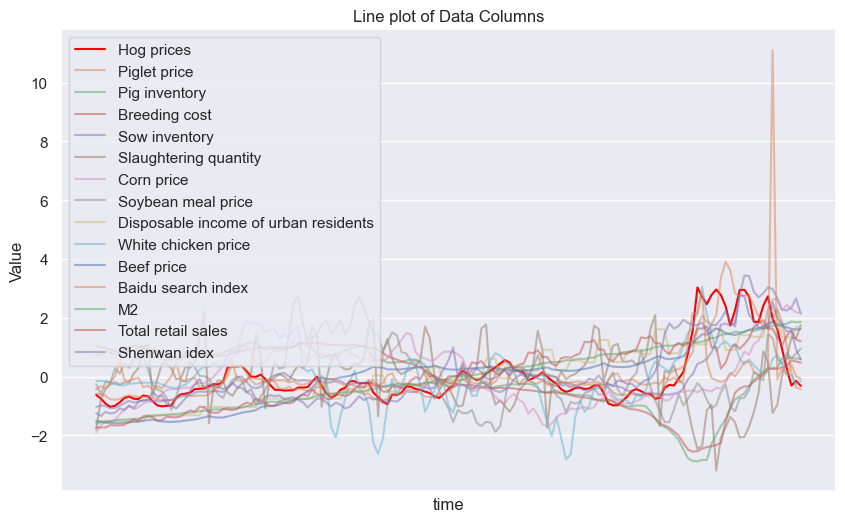

In [81]:
import matplotlib.pyplot as plt
from matplotlib.dates import datestr2num,DateFormatter

# 获取除num列外的所有列名
columns = final_data.columns.tolist()
columns.remove('num')

# 创建子图
fig, ax = plt.subplots(figsize=(10, 6))

# 遍历每个列名，并绘制折线图
for i, column in enumerate(columns):
    if column == 'Hog prices':
        # 如果是price列，使用较深的颜色进行突出显示
        ax.plot(final_data['num'], final_data[column], label=column, color='red')
    else:
        # 对于其他列，使用较淡的颜色
        color = f'C{i}'  # 根据索引i选择不同的颜色
        ax.plot(final_data['num'], final_data[column], label=column, color=color, alpha=0.5)

# 设置x轴日期格式
date_ticks = ['2009-02', '2021-08']
date_num = datestr2num(date_ticks)
date_formatter = DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(plt.FixedLocator(date_num))
ax.xaxis.set_major_formatter(date_formatter)

# 设置图形属性
ax.set_xlabel('time')
ax.set_ylabel('Value')
ax.set_title('Line plot of Data Columns')
ax.legend()

# 显示图形
plt.show()


## Data standard

In [61]:
#先标准化和后标准化选择的特征变量结果一致
from sklearn.preprocessing import StandardScaler

# 选择除了 "num" 列以外的数据列
data_columns = final_data.columns.drop("num")
data = final_data[data_columns]

# 使用 StandardScaler 对数据进行标准化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 将标准化后的数据替换原始数据中除了 "num" 列以外的数据
final_data[data_columns] = scaled_data

## Feature extraction, feature selection

In [62]:
#使用滞后期，选择7个
# 按照滞后期和预测步长进行特征提取
lag = 12
prediction_step = 12

# 提取特征列和目标变量列
X = final_data.drop(['Hog prices','num'], axis=1)
y = final_data['Hog prices']

# 滞后期处理
X_lagged = X.shift(lag)
y_lagged = y.shift(-prediction_step)

# 去除滞后期导致的缺失值
X_lagged = X_lagged.iloc[:-prediction_step]
y_lagged = y_lagged.iloc[:-prediction_step]
# 去除滞后期导致的缺失值
X_lagged_dropna = X_lagged.dropna().reset_index(drop=True)
y_lagged_dropna = y_lagged.dropna().reset_index(drop=True)

# 重新设置索引
y_lagged_dropna = y_lagged_dropna.reindex(X_lagged_dropna.index)

assert X_lagged_dropna.shape[0] == y_lagged_dropna.shape[0]

# 进行特征选择
selector = SelectKBest(score_func=mutual_info_regression, k=7)  # 选择前7个特征
X_selected = selector.fit_transform(X_lagged_dropna, y_lagged_dropna)

selected_columns = X.columns[selector.get_support()]
print("被选择的特征列:")
for column in selected_columns:
    print(column)

被选择的特征列:
Pig inventory
Breeding cost
Sow inventory
Disposable income of urban residents
Beef price
M2
Total retail sales


## Data set

In [63]:
#构造X集，无滞后期
X_selected_columns = ['Pig inventory', 'Breeding cost', 'Sow inventory', 'Disposable income of urban residents', 'Beef price', 'M2', 'Total retail sales', 'num']
final_data_feature_lag = final_data[selected_columns]


#构造Y集
y_selected_columns = ['Hog prices']
final_data_feature_lag = final_data[selected_columns]

In [161]:
# print(final_data_feature_lag)

         Pig inventory  Breeding cost  Sow inventory  \
2009-02       0.721782       1.036882      -1.034265   
2009-03       0.759559       0.984301      -0.987471   
2009-04       0.848412       0.960932      -1.005582   
2009-05       0.825209       0.911856      -1.078554   
2009-06       0.739609       0.855770      -1.068123   
...                ...            ...            ...   
2021-04       0.625146       0.310681       2.271857   
2021-05       0.625146       0.351488       2.248155   
2021-06       0.625146       0.542623       2.341478   
2021-07       0.604348       0.515748       2.656602   
2021-08       0.604348       0.467841       2.136916   

         Disposable income of urban residents  Beef price        M2  \
2009-02                             -1.515185   -1.510606 -1.601250   
2009-03                             -1.515185   -1.548264 -1.555362   
2009-04                             -1.515185   -1.568406 -1.536457   
2009-05                             -1.5151

In [181]:
lag = 12  # 滞后期

# 选取需要的列
selected_columns = ['Pig inventory', 'Breeding cost', 'Sow inventory', 'Disposable income of urban residents', 'Beef price', 'M2', 'Total retail sales']
X_final_data_feature_lag12 = final_data[selected_columns]

# 创建滞后期特征
for col in selected_columns:
    for i in range(1, lag+1):
        X_final_data_feature_lag12[f"{col}_lag{i}"] = X_final_data_feature_lag12[col].shift(i)

# 添加 num 列
X_final_data_feature_lag12['num'] = final_data['num']

# 去除包含 NaN 值的行
X_final_data_feature_lag12 = X_final_data_feature_lag12.dropna()

# 输出修改后的数据集
print(len(X_final_data_feature_lag12))

y_selected_columns = ['num', 'Hog prices']
# 添加 num 列
y_final_data_feature_lag12 = final_data[y_selected_columns].iloc[12:]

# 输出修改后的数据集
print(X_final_data_feature_lag12)

# 去掉 'num' 列
X_final_data_feature_lag12_cnn = X_final_data_feature_lag12.drop('num', axis=1)
y_final_data_feature_lag12_cnn = y_final_data_feature_lag12.drop('num', axis=1)



139
         Pig inventory  Breeding cost  Sow inventory  \
2010-02       0.684429       0.923541      -0.818751   
2010-03       0.656132       0.865118      -0.845806   
2010-04       0.581144       0.771641      -0.842909   
2010-05       0.548602       0.701534      -0.812823   
2010-06       0.591048       0.678164      -0.789912   
...                ...            ...            ...   
2021-04       0.625146       0.310681       2.271857   
2021-05       0.625146       0.351488       2.248155   
2021-06       0.625146       0.542623       2.341478   
2021-07       0.604348       0.515748       2.656602   
2021-08       0.604348       0.467841       2.136916   

         Disposable income of urban residents  Beef price        M2  \
2010-02                             -1.317495   -1.463860 -1.353067   
2010-03                             -1.317495   -1.502659 -1.326448   
2010-04                             -1.317495   -1.527613 -1.313759   
2010-05                             -1.

C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3149922603.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_final_data_feature_lag12[f"{col}_lag{i}"] = X_final_data_feature_lag12[col].shift(i)
C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3149922603.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_final_data_feature_lag12[f"{col}_lag{i}"] = X_final_data_feature_lag12[col].shift(i)
C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3149922603.py:12: SettingWithCopyWarning: 
A value is trying

#  ML Prediction

In [94]:
import scipy.stats as st
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression


## RMSE

In [281]:
# 创建基础模型对象
base_model_b = RandomForestRegressor()
# 创建基础模型对象
base_model_o = DecisionTreeRegressor()
# 创建基础模型对象
base_models = [
    ('model1', DecisionTreeRegressor()),
    ('model2', Ridge())
]

# 创建Bagging模型对象
bagging_model = BaggingRegressor(estimator=base_model_b)
# 创建Boosting模型对象
boosting_model = AdaBoostRegressor(estimator=base_model_o)
# 创建Stacking模型对象
stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

names = ["Linear Regression", "Ridge Regression", "Lasso Regression",
         "Decision Tree Regressor", "Random Forest Regressor", "Gradient Boosting Regressor",
         "Adaboost Regressor", "BaggingRegressor", "ExtraTreesRegressor",
         "XGBRegressor", "XGBRFRegressor", "LightGBM", "SVM","bagging", 'boosting', 'stacking']

models = [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(),
          AdaBoostRegressor(), BaggingRegressor(), ExtraTreesRegressor(),
          XGBRegressor(), XGBRFRegressor(), LGBMRegressor(), SVR(),bagging_model, boosting_model, stacking_model]


# 指定训练集和测试集的范围
train_num = 1
train_start = 12
train_end = 100
test_start = 101
test_end = 151
current_train_end = train_end

evaluation_results = []

# 划分训练集和测试集
# 获取 'num' 列对应数字为 train_start:current_train_end 范围内的行索引
num_indices_te = X_final_data_feature_lag12.loc[(X_final_data_feature_lag12['num'] >= test_start) & (X_final_data_feature_lag12['num'] <= test_end)].index

# 使用相同的行索引选择测试集特征和目标变量
X_test = X_final_data_feature_lag12.loc[num_indices_te, X_final_data_feature_lag12.columns != 'num']
y_test = y_final_data_feature_lag12.loc[num_indices_te, 'Hog prices']



while train_end <= test_end:
    # 打印循环次数
    print("This is the {}th loop.".format(train_num))
    
    # 清空评估结果列表
    evaluation_results.clear()

     # 划分训练集和测试集
    # 获取 'num' 列对应数字为 train_start:current_train_end 范围内的行索引
    num_indices_tr = (X_final_data_feature_lag12['num'] >= train_start-1) & (X_final_data_feature_lag12['num'] <= current_train_end-1)
    # 获取 'num' 列对应数字为 test_start:test_end 范围内的行索引
    num_indices_te = (X_final_data_feature_lag12['num'] >= test_start-1) & (X_final_data_feature_lag12['num'] <= test_end-1)
    # 选择对应行索引的其他列数据作为训练集特征，同时移除 'num' 列
    X_train_features = X_final_data_feature_lag12.drop('num', axis=1)
    X_train_features = X_train_features.loc[num_indices_tr]
    # 选择对应行索引的其他列数据作为测试集特征，同时移除 'num' 列
    X_test_features = X_final_data_feature_lag12.drop('num', axis=1)
    X_test_features = X_test_features.loc[num_indices_te]
    y_test = y_final_data_feature_lag12.loc[num_indices_te].drop('num', axis=1)['Hog prices']
    y_train = y_final_data_feature_lag12.loc[num_indices_tr].drop('num', axis=1)['Hog prices']
    
    
    # 初始化评估指标列表
    MAE = []
    MSE = []
    RMSE = []
    R_Square = []
    adj_rsquared = []
    CV = []

    def evaluate(true, predicted, variable_of_model):
        MAE.append(mean_absolute_error(true, predicted))
        MSE.append(mean_squared_error(true, predicted))
        RMSE.append(np.sqrt(mean_squared_error(true, predicted)))
        R_Square.append(variable_of_model.score(X_test_features, y_test))  # 修改此行
        n = X_test_features.shape[0]
        p = X_test_features.shape[1] - 1
        adj_rsquared.append(1 - (1 - R_Square[-1]) * ((n - 1) / (n - p - 1)))
        cv_accuracies = cross_val_score(estimator=variable_of_model, X=X_train_features, y=y_train.ravel(), cv=5, verbose=1)
        CV.append(cv_accuracies.mean())

    def print_evaluate(true, predicted):
        mae = mean_absolute_error(true, predicted)
        mse = mean_squared_error(true, predicted)
        rmse = np.sqrt(mean_squared_error(true, predicted))
        r2_square = r2_score(true, predicted)
        n = X_test_features.shape[0]
        p = X_test_features.shape[1] - 1
        adj_rsquared = 1 - (1 - r2_square) * ((n - 1) / (n - p - 1))
        print("MAE:", mae)
        print("MSE:", mse)
        print("RMSE:", rmse)
        print("R2 Square", r2_square)
        print("adj R Square", adj_rsquared)

    def fit_and_predict(name, model):
        variable_of_model = model
        variable_of_model.fit(X_train_features, y_train.ravel())
        pred = variable_of_model.predict(X_test_features)
        evaluate(y_test, pred, variable_of_model)

        evaluation_results.append({
            "Model": name,
            "MAE": MAE[-1],
            "MSE": MSE[-1],
            "RMSE": RMSE[-1],
            "R Squared": R_Square[-1],
            "adj R Squared": adj_rsquared[-1],
            "Cross Validation": CV[-1]
        })

    # 声明变量存储最小RMSE(CV)和对应的算法
    min_rmse_cv = float('inf')
    best_model = None

    for name, model in zip(names, models):
        fit_and_predict(name, model)

    # 创建评估结果DataFrame
    evaluation_dataframe = pd.DataFrame(evaluation_results)
    evaluation_dataframe = evaluation_dataframe.sort_values("RMSE")

    # 打印评估结果DataFrame
    print(evaluation_dataframe)
    
    
    # 使用最小RMSE的模型进行未来12期的预测
    # 找到评估结果DataFrame中最小RMSE对应的算法
    best_row = evaluation_dataframe.loc[evaluation_dataframe['RMSE'].idxmin()]
    best_model_name = best_row['Model']
    best_model = models[names.index(best_model_name)]


    # 使用最小RMSE的模型进行未来12期的预测
    num_indices_p = (X_final_data_feature_lag12['num'] >= current_train_end + 1) & (X_final_data_feature_lag12['num'] <= current_train_end + 12)

    if num_indices_p.sum() == 12:
        print('ok')
        future_X_features = X_final_data_feature_lag12.drop('num', axis=1)
        future_X_features = future_X_features.loc[num_indices_p]
        future_predictions = best_model.predict(future_X_features)
    
    else:
        
        future_predictions = []
        current_input_sequence = X_final_data_feature_lag12_cnn[-12:].values
        print('fine')

        for _ in range(12):
            current_input_sequence = current_input_sequence.reshape((12, 91))
#             print("current_input_sequence shape:", current_input_sequence.shape)
            prediction = best_model.predict(current_input_sequence)
            future_predictions.append(prediction)
            current_input_sequence = np.roll(current_input_sequence, -1, axis=0)
            current_input_sequence[-1] = np.squeeze(prediction)[-1]
            prediction = np.squeeze(prediction)
            

    # 打印预测结果
    future_predictions = np.array(best_model.predict(future_X_features))
    mean = raw_data["Hog prices"].mean()
    std = raw_data["Hog prices"].std()

    # Reverse standardization and print the predictions
    print("Predictions for the next 12 periods ({}-{}) using {}:".format(current_train_end+1, current_train_end+12, best_model_name))
    future_predictions_reversed = future_predictions * std + mean
    print("Reversed Predictions for the next 12 periods:")
    print(future_predictions_reversed)
    print("Predictions for the next 12 periods:")
    print(future_predictions)

    # 更新下一个训练集和测试集的起始和结束行数
    current_train_end += 1
    train_end += 1
    train_num += 1

This is the 1th loop.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE        MSE      RMSE  R Squared  \
15                     stacking  0.914743   1.664411  1.290121   0.171125   
1              Ridge Regression  1.153880   2.182073  1.477184  -0.086670   
9                  XGBRegressor  1.269764   2.246201  1.498733  -0.118606   
8           ExtraTreesRegressor  1.238871   2.316146  1.521889  -0.153439   
3       Decision Tree Regressor  1.225855   2.337684  1.528949  -0.164165   
5   Gradient Boosting Regressor  1.284549   2.487554  1.577198  -0.238800   
11                     LightGBM  1.298248   2.509446  1.584123  -0.249702   
13                      bagging  1.271205   2.563845  1.601201  -0.276793   
10               XGBRFRegressor  1.268995   2.577733  1.605532  -0.283709   
4       Random Forest Regressor  1.282402   2.632936  1.622632  -0.311200   
14                     boosting  1.299351   2.726882  1.651327  -0.357985   
6            Adaboost Regressor  1.345029   2.793062  1.671246  -0.390943   

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE        MSE      RMSE  R Squared  \
15                     stacking  0.924997   1.692000  1.300769   0.157385   
1              Ridge Regression  1.117016   2.148626  1.465819  -0.070014   
3       Decision Tree Regressor  1.233329   2.367001  1.538506  -0.178764   
9                  XGBRegressor  1.255602   2.417148  1.554718  -0.203738   
5   Gradient Boosting Regressor  1.279253   2.595440  1.611037  -0.292527   
6            Adaboost Regressor  1.285768   2.619073  1.618355  -0.304296   
10               XGBRFRegressor  1.265772   2.621722  1.619173  -0.305615   
7              BaggingRegressor  1.296495   2.626573  1.620671  -0.308031   
13                      bagging  1.258174   2.627024  1.620810  -0.308256   
11                     LightGBM  1.309674   2.639668  1.624705  -0.314552   
14                     boosting  1.278268   2.669070  1.633729  -0.329195   
8           ExtraTreesRegressor  1.236204   2.674767  1.635471  -0.332032   

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
15                     stacking  1.074981  2.133719  1.460726  -0.062590   
1              Ridge Regression  1.133524  2.318837  1.522773  -0.154779   
3       Decision Tree Regressor  1.226391  2.369954  1.539466  -0.180235   
9                  XGBRegressor  1.261479  2.511845  1.584880  -0.250897   
11                     LightGBM  1.256799  2.553433  1.597946  -0.271607   
6            Adaboost Regressor  1.266996  2.616451  1.617545  -0.302991   
10               XGBRFRegressor  1.240327  2.617316  1.617812  -0.303421   
5   Gradient Boosting Regressor  1.250461  2.701216  1.643538  -0.345203   
13                      bagging  1.273501  2.753104  1.659248  -0.371043   
4       Random Forest Regressor  1.266651  2.780640  1.667525  -0.384756   
8           ExtraTreesRegressor  1.234284  2.884651  1.698426  -0.436554   
2              Lasso Regression  1.203084  2.893497  1.701028  -0.440959   
7           

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
15                     stacking  1.044506  2.056762  1.434142  -0.024266   
9                  XGBRegressor  1.230682  2.312338  1.520637  -0.151543   
3       Decision Tree Regressor  1.270091  2.453326  1.566310  -0.221754   
7              BaggingRegressor  1.242701  2.534282  1.591943  -0.262070   
10               XGBRFRegressor  1.230871  2.554131  1.598165  -0.271955   
1              Ridge Regression  1.205792  2.585909  1.608076  -0.287781   
11                     LightGBM  1.250506  2.593951  1.610575  -0.291786   
5   Gradient Boosting Regressor  1.233125  2.615871  1.617366  -0.302702   
4       Random Forest Regressor  1.237411  2.643475  1.625877  -0.316449   
13                      bagging  1.245314  2.660095  1.630980  -0.324725   
14                     boosting  1.275211  2.686341  1.639006  -0.337796   
6            Adaboost Regressor  1.284226  2.707001  1.645297  -0.348084   
8           

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Us

                          Model        MAE         MSE       RMSE   R Squared  \
3       Decision Tree Regressor   1.186076    2.133737   1.460732   -0.062599   
9                  XGBRegressor   1.224244    2.383655   1.543909   -0.187058   
15                     stacking   1.168602    2.503094   1.582117   -0.246539   
10               XGBRFRegressor   1.232327    2.534793   1.592103   -0.262325   
6            Adaboost Regressor   1.262091    2.592373   1.610085   -0.290999   
11                     LightGBM   1.263554    2.621397   1.619073   -0.305454   
5   Gradient Boosting Regressor   1.229694    2.631996   1.622343   -0.310732   
4       Random Forest Regressor   1.241129    2.638766   1.624428   -0.314103   
13                      bagging   1.215383    2.639874   1.624769   -0.314655   
7              BaggingRegressor   1.241221    2.682287   1.637769   -0.335777   
14                     boosting   1.264960    2.721757   1.649775   -0.355433   
1              Ridge Regress

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model        MAE          MSE       RMSE  \
15                     stacking   1.090512     2.169639   1.472969   
7              BaggingRegressor   1.198147     2.411997   1.553060   
3       Decision Tree Regressor   1.264470     2.475946   1.573514   
10               XGBRFRegressor   1.225114     2.509819   1.584241   
9                  XGBRegressor   1.266588     2.533717   1.591766   
4       Random Forest Regressor   1.226488     2.551726   1.597412   
14                     boosting   1.224487     2.568640   1.602698   
5   Gradient Boosting Regressor   1.236778     2.589155   1.609085   
11                     LightGBM   1.255674     2.592898   1.610248   
13                      bagging   1.233421     2.641935   1.625403   
1              Ridge Regression   1.225922     2.656092   1.629752   
6            Adaboost Regressor   1.258661     2.713244   1.647193   
8           ExtraTreesRegressor   1.210098     2.842574   1.685994   
2              Lasso

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model        MAE         MSE       RMSE   R Squared  \
15                     stacking   1.090175    2.236926   1.495636   -0.113987   
1              Ridge Regression   1.167831    2.440510   1.562213   -0.215372   
7              BaggingRegressor   1.237877    2.470201   1.571687   -0.230158   
9                  XGBRegressor   1.257594    2.477108   1.573883   -0.233598   
10               XGBRFRegressor   1.202956    2.491009   1.578293   -0.240521   
3       Decision Tree Regressor   1.255571    2.499945   1.581122   -0.244971   
6            Adaboost Regressor   1.227119    2.531005   1.590913   -0.260438   
4       Random Forest Regressor   1.236297    2.567622   1.602380   -0.278674   
11                     LightGBM   1.236954    2.574053   1.604385   -0.281876   
5   Gradient Boosting Regressor   1.226661    2.582342   1.606967   -0.286004   
13                      bagging   1.239894    2.696538   1.642114   -0.342874   
14                     boost

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model        MAE         MSE       RMSE   R Squared  \
3       Decision Tree Regressor   1.171967    2.125307   1.457843   -0.058401   
1              Ridge Regression   1.097593    2.184997   1.478174   -0.088127   
7              BaggingRegressor   1.213046    2.446001   1.563970   -0.218107   
10               XGBRFRegressor   1.203080    2.511542   1.584785   -0.250746   
9                  XGBRegressor   1.254865    2.528518   1.590131   -0.259200   
15                     stacking   1.182887    2.549285   1.596648   -0.269542   
4       Random Forest Regressor   1.216728    2.593678   1.610490   -0.291649   
14                     boosting   1.232291    2.620300   1.618734   -0.304907   
13                      bagging   1.232410    2.639797   1.624745   -0.314617   
11                     LightGBM   1.239354    2.658601   1.630522   -0.323981   
5   Gradient Boosting Regressor   1.207770    2.696918   1.642229   -0.343063   
6            Adaboost Regres

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE         MSE       RMSE  R Squared  \
1              Ridge Regression  1.005900    1.852663   1.361126   0.077375   
3       Decision Tree Regressor  1.088549    2.006941   1.416665   0.000545   
15                     stacking  1.073945    2.257344   1.502446  -0.124156   
10               XGBRFRegressor  1.155062    2.466875   1.570629  -0.228502   
9                  XGBRegressor  1.167180    2.471001   1.571942  -0.230556   
6            Adaboost Regressor  1.205396    2.528025   1.589976  -0.258954   
4       Random Forest Regressor  1.196645    2.591875   1.609930  -0.290752   
7              BaggingRegressor  1.236726    2.618031   1.618033  -0.303777   
11                     LightGBM  1.212585    2.674629   1.635429  -0.331963   
13                      bagging  1.216147    2.679595   1.636947  -0.334436   
5   Gradient Boosting Regressor  1.180694    2.754382   1.659633  -0.371680   
14                     boosting  1.197134    2.80277

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE         MSE       RMSE  R Squared  \
1              Ridge Regression  0.966017    1.709688   1.307550   0.148577   
3       Decision Tree Regressor  1.087502    2.005624   1.416200   0.001201   
10               XGBRFRegressor  1.156314    2.471023   1.571949  -0.230567   
14                     boosting  1.182087    2.497962   1.580494  -0.243983   
4       Random Forest Regressor  1.183500    2.579880   1.606200  -0.284778   
9                  XGBRegressor  1.214249    2.593641   1.610479  -0.291631   
13                      bagging  1.195432    2.654124   1.629148  -0.321751   
5   Gradient Boosting Regressor  1.174484    2.718210   1.648700  -0.353666   
11                     LightGBM  1.209924    2.720306   1.649335  -0.354710   
7              BaggingRegressor  1.208217    2.753497   1.659367  -0.371239   
6            Adaboost Regressor  1.241204    2.754328   1.659617  -0.371653   
8           ExtraTreesRegressor  1.164619    2.85831

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE         MSE       RMSE  R Squared  \
1              Ridge Regression  0.997269    1.821649   1.349685   0.092820   
3       Decision Tree Regressor  1.086366    2.049176   1.431494  -0.020488   
10               XGBRFRegressor  1.132673    2.478505   1.574327  -0.234293   
15                     stacking  1.149785    2.613922   1.616763  -0.301731   
4       Random Forest Regressor  1.190894    2.628390   1.621231  -0.308936   
9                  XGBRegressor  1.221738    2.637314   1.623981  -0.313380   
14                     boosting  1.197530    2.647684   1.627171  -0.318545   
13                      bagging  1.185927    2.681812   1.637624  -0.335540   
5   Gradient Boosting Regressor  1.164767    2.734210   1.653545  -0.361634   
7              BaggingRegressor  1.231257    2.771610   1.664815  -0.380259   
6            Adaboost Regressor  1.211279    2.772489   1.665079  -0.380697   
11                     LightGBM  1.199134    2.83483

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE         MSE       RMSE  R Squared  \
3       Decision Tree Regressor  1.086882    2.023086   1.422352  -0.007495   
1              Ridge Regression  1.085984    2.182978   1.477490  -0.087121   
10               XGBRFRegressor  1.136435    2.629038   1.621431  -0.309259   
13                      bagging  1.184303    2.813786   1.677434  -0.401263   
14                     boosting  1.172737    2.869308   1.693903  -0.428913   
2              Lasso Regression  1.203095    2.924879   1.710228  -0.456587   
11                     LightGBM  1.212336    2.977468   1.725534  -0.482777   
4       Random Forest Regressor  1.199108    2.990558   1.729323  -0.489295   
6            Adaboost Regressor  1.266039    3.002782   1.732854  -0.495383   
7              BaggingRegressor  1.204363    3.080232   1.755059  -0.533953   
5   Gradient Boosting Regressor  1.209628    3.138090   1.771465  -0.562766   
15                     stacking  1.291252    3.29354

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE        MSE      RMSE  R Squared  \
3       Decision Tree Regressor  1.077954   2.055284  1.433626  -0.023530   
1              Ridge Regression  1.141768   2.416025  1.554357  -0.203178   
2              Lasso Regression  1.203425   2.938181  1.714112  -0.463212   
13                      bagging  1.206667   3.016690  1.736862  -0.502309   
11                     LightGBM  1.224339   3.178880  1.782941  -0.583080   
14                     boosting  1.210364   3.199981  1.788849  -0.593588   
6            Adaboost Regressor  1.301436   3.216223  1.793383  -0.601676   
4       Random Forest Regressor  1.226675   3.249857  1.802736  -0.618426   
7              BaggingRegressor  1.279467   3.257801  1.804938  -0.622382   
10               XGBRFRegressor  1.219640   3.307381  1.818621  -0.647073   
5   Gradient Boosting Regressor  1.248586   3.430460  1.852150  -0.708366   
9                  XGBRegressor  1.320890   3.581039  1.892363  -0.783354   

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE        MSE      RMSE  R Squared  \
1              Ridge Regression  1.177518   2.569932  1.603101  -0.279824   
15                     stacking  1.149765   2.653321  1.628902  -0.321352   
2              Lasso Regression  1.204280   2.951246  1.717919  -0.469718   
13                      bagging  1.217837   3.139215  1.771783  -0.563326   
11                     LightGBM  1.241033   3.357615  1.832380  -0.672089   
4       Random Forest Regressor  1.232708   3.373379  1.836676  -0.679940   
7              BaggingRegressor  1.243377   3.433706  1.853026  -0.709982   
5   Gradient Boosting Regressor  1.229129   3.434549  1.853254  -0.710402   
6            Adaboost Regressor  1.279366   3.532494  1.879493  -0.759179   
14                     boosting  1.290852   3.674935  1.917012  -0.830115   
10               XGBRFRegressor  1.312172   3.693282  1.921791  -0.839251   
8           ExtraTreesRegressor  1.326212   3.891133  1.972595  -0.937781   

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE        MSE      RMSE  R Squared  \
1              Ridge Regression  1.185474   2.600677  1.612662  -0.295135   
15                     stacking  1.202562   2.933523  1.712753  -0.460892   
2              Lasso Regression  1.205196   2.961357  1.720859  -0.474753   
13                      bagging  1.195497   3.114279  1.764732  -0.550908   
11                     LightGBM  1.238925   3.430634  1.852197  -0.708453   
4       Random Forest Regressor  1.258544   3.550329  1.884232  -0.768061   
10               XGBRFRegressor  1.268593   3.551147  1.884449  -0.768468   
7              BaggingRegressor  1.258807   3.554564  1.885355  -0.770170   
14                     boosting  1.262583   3.587772  1.894142  -0.786708   
5   Gradient Boosting Regressor  1.250730   3.593328  1.895608  -0.789474   
6            Adaboost Regressor  1.281446   3.623650  1.903589  -0.804574   
8           ExtraTreesRegressor  1.335956   3.891074  1.972581  -0.937752   

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE        MSE      RMSE  R Squared  \
15                     stacking  1.093459   2.375488  1.541262  -0.182991   
1              Ridge Regression  1.180946   2.585645  1.607994  -0.287649   
2              Lasso Regression  1.205844   2.968540  1.722945  -0.478330   
13                      bagging  1.188372   3.082501  1.755705  -0.535083   
7              BaggingRegressor  1.171454   3.121633  1.766814  -0.554571   
6            Adaboost Regressor  1.197490   3.207629  1.790985  -0.597397   
4       Random Forest Regressor  1.235942   3.430371  1.852126  -0.708322   
10               XGBRFRegressor  1.247036   3.497485  1.870156  -0.741745   
11                     LightGBM  1.255749   3.503845  1.871856  -0.744912   
5   Gradient Boosting Regressor  1.245597   3.518970  1.875892  -0.752444   
14                     boosting  1.273137   3.629175  1.905039  -0.807326   
9                  XGBRegressor  1.295689   3.739070  1.933667  -0.862054   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE        MSE      RMSE  R Squared  \
1              Ridge Regression  1.168207   2.549470  1.596706  -0.269634   
15                     stacking  1.201249   2.912102  1.706488  -0.450225   
2              Lasso Regression  1.206148   2.971921  1.723926  -0.480014   
13                      bagging  1.185529   3.045934  1.745260  -0.516872   
5   Gradient Boosting Regressor  1.184912   3.185782  1.784876  -0.586517   
14                     boosting  1.204651   3.255542  1.804312  -0.621257   
3       Decision Tree Regressor  1.187710   3.315616  1.820883  -0.651174   
4       Random Forest Regressor  1.231488   3.407904  1.846051  -0.697134   
10               XGBRFRegressor  1.220835   3.412736  1.847359  -0.699539   
6            Adaboost Regressor  1.250319   3.439319  1.854540  -0.712778   
8           ExtraTreesRegressor  1.229616   3.487754  1.867553  -0.736899   
7              BaggingRegressor  1.263201   3.574744  1.890699  -0.780220   

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE        MSE      RMSE  R Squared  \
15                     stacking  1.099519   2.433386  1.559931  -0.211824   
1              Ridge Regression  1.157197   2.522119  1.588118  -0.256013   
2              Lasso Regression  1.206328   2.973928  1.724508  -0.481014   
13                      bagging  1.195786   3.141422  1.772406  -0.564425   
5   Gradient Boosting Regressor  1.177649   3.193018  1.786902  -0.590121   
4       Random Forest Regressor  1.202693   3.252187  1.803382  -0.619586   
7              BaggingRegressor  1.212347   3.254371  1.803988  -0.620674   
10               XGBRFRegressor  1.206562   3.358126  1.832519  -0.672344   
11                     LightGBM  1.227475   3.419330  1.849143  -0.702823   
6            Adaboost Regressor  1.246627   3.421576  1.849750  -0.703942   
14                     boosting  1.235632   3.445455  1.856194  -0.715834   
9                  XGBRegressor  1.241065   3.485617  1.866981  -0.735834   

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE        MSE      RMSE  R Squared  \
15                     stacking  1.102215   2.440928  1.562347  -0.215580   
1              Ridge Regression  1.152110   2.508421  1.583800  -0.249192   
2              Lasso Regression  1.206629   2.977283  1.725480  -0.482684   
5   Gradient Boosting Regressor  1.155306   3.041647  1.744032  -0.514738   
13                      bagging  1.186831   3.097284  1.759910  -0.542445   
7              BaggingRegressor  1.194537   3.232222  1.797838  -0.609644   
4       Random Forest Regressor  1.207464   3.281118  1.811386  -0.633994   
9                  XGBRegressor  1.206313   3.330577  1.824987  -0.658625   
14                     boosting  1.208590   3.340066  1.827585  -0.663350   
10               XGBRFRegressor  1.204849   3.347112  1.829511  -0.666859   
6            Adaboost Regressor  1.254204   3.451846  1.857914  -0.719016   
11                     LightGBM  1.242579   3.454533  1.858637  -0.720355   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
0             Linear Regression  1.019792  2.298339  1.516027  -0.144571   
1              Ridge Regression  1.152873  2.510773  1.584542  -0.250363   
15                     stacking  1.163416  2.647388  1.627080  -0.318397   
5   Gradient Boosting Regressor  1.114406  2.849963  1.688183  -0.419279   
2              Lasso Regression  1.207065  2.982147  1.726889  -0.485107   
13                      bagging  1.211092  3.199819  1.788804  -0.593507   
10               XGBRFRegressor  1.191865  3.278513  1.810666  -0.632697   
9                  XGBRegressor  1.196249  3.291658  1.814293  -0.639243   
6            Adaboost Regressor  1.247412  3.399741  1.843839  -0.693068   
4       Random Forest Regressor  1.239486  3.450700  1.857606  -0.718446   
14                     boosting  1.256144  3.582292  1.892694  -0.783978   
7              BaggingRegressor  1.273636  3.582307  1.892698  -0.783986   
8           

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
0             Linear Regression  0.612790  0.879083  0.937594   0.562218   
1              Ridge Regression  1.151136  2.505552  1.582894  -0.247763   
15                     stacking  1.173254  2.617350  1.617823  -0.303438   
5   Gradient Boosting Regressor  1.116325  2.874819  1.695529  -0.431657   
2              Lasso Regression  1.207502  2.987043  1.728306  -0.487545   
13                      bagging  1.199072  3.178707  1.782893  -0.582994   
10               XGBRFRegressor  1.184349  3.256335  1.804532  -0.621652   
9                  XGBRegressor  1.190905  3.265558  1.807085  -0.626245   
7              BaggingRegressor  1.212663  3.265639  1.807108  -0.626285   
4       Random Forest Regressor  1.247241  3.470258  1.862863  -0.728185   
6            Adaboost Regressor  1.270062  3.508461  1.873089  -0.747211   
14                     boosting  1.251722  3.553011  1.884943  -0.769396   
11          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
15                     stacking  1.089520  2.366305  1.538280  -0.178418   
1              Ridge Regression  1.152782  2.511514  1.584776  -0.250732   
5   Gradient Boosting Regressor  1.119878  2.876853  1.696129  -0.432670   
2              Lasso Regression  1.208204  2.994931  1.730587  -0.491473   
9                  XGBRegressor  1.176074  3.188874  1.785742  -0.588056   
7              BaggingRegressor  1.203227  3.211266  1.792001  -0.599208   
10               XGBRFRegressor  1.209036  3.351414  1.830687  -0.669001   
13                      bagging  1.245175  3.392978  1.842004  -0.689700   
0             Linear Regression  1.093172  3.400490  1.844042  -0.693441   
4       Random Forest Regressor  1.250476  3.509792  1.873444  -0.747874   
14                     boosting  1.258180  3.573783  1.890445  -0.779741   
11                     LightGBM  1.255897  3.575786  1.890975  -0.780738   
6           

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
15                     stacking  0.857325  1.540938  1.241345   0.232614   
1              Ridge Regression  1.130912  2.434579  1.560314  -0.212418   
5   Gradient Boosting Regressor  1.132575  2.955624  1.719193  -0.471898   
2              Lasso Regression  1.208839  3.002094  1.732655  -0.495040   
10               XGBRFRegressor  1.195857  3.251192  1.803106  -0.619091   
6            Adaboost Regressor  1.232633  3.329072  1.824574  -0.657875   
13                      bagging  1.240816  3.338651  1.827198  -0.662645   
14                     boosting  1.236419  3.481563  1.865895  -0.733816   
4       Random Forest Regressor  1.258946  3.529503  1.878697  -0.757689   
9                  XGBRegressor  1.251019  3.556250  1.885802  -0.771010   
7              BaggingRegressor  1.270825  3.570850  1.889669  -0.778280   
11                     LightGBM  1.271513  3.635207  1.906622  -0.810330   
8           

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
15                     stacking  0.957126  1.880038  1.371145   0.063743   
1              Ridge Regression  1.090266  2.273989  1.507975  -0.132444   
5   Gradient Boosting Regressor  1.073401  2.759611  1.661208  -0.374284   
7              BaggingRegressor  1.120503  2.859213  1.690921  -0.423886   
2              Lasso Regression  1.208917  3.002975  1.732909  -0.495479   
10               XGBRFRegressor  1.151799  3.102278  1.761329  -0.544932   
4       Random Forest Regressor  1.189916  3.235641  1.798789  -0.611347   
9                  XGBRegressor  1.167862  3.280140  1.811116  -0.633507   
14                     boosting  1.207615  3.377335  1.837753  -0.681910   
6            Adaboost Regressor  1.256951  3.433530  1.852979  -0.709895   
13                      bagging  1.253907  3.444607  1.855965  -0.715411   
8           ExtraTreesRegressor  1.227833  3.552470  1.884800  -0.769127   
3       Deci

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
15                     stacking  0.873946  1.617423  1.271779   0.194525   
1              Ridge Regression  1.082829  2.263052  1.504344  -0.126998   
5   Gradient Boosting Regressor  1.071326  2.793018  1.671232  -0.390921   
9                  XGBRegressor  1.099957  2.953056  1.718446  -0.470620   
2              Lasso Regression  1.208840  3.002104  1.732658  -0.495045   
10               XGBRFRegressor  1.148429  3.135470  1.770726  -0.561461   
13                      bagging  1.209236  3.217225  1.793662  -0.602175   
7              BaggingRegressor  1.188141  3.229075  1.796963  -0.608077   
4       Random Forest Regressor  1.191071  3.254387  1.803992  -0.620682   
6            Adaboost Regressor  1.217139  3.267205  1.807541  -0.627065   
14                     boosting  1.195254  3.374947  1.837103  -0.680721   
8           ExtraTreesRegressor  1.179507  3.382758  1.839227  -0.684610   
12          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
15                     stacking  0.905117  1.695519  1.302121   0.155633   
1              Ridge Regression  1.086819  2.314851  1.521463  -0.152794   
9                  XGBRegressor  1.001997  2.491655  1.578498  -0.240842   
5   Gradient Boosting Regressor  1.059329  2.722731  1.650070  -0.355918   
0             Linear Regression  0.950336  2.804238  1.674586  -0.396508   
2              Lasso Regression  1.208793  3.001576  1.732506  -0.494783   
14                     boosting  1.135169  3.087407  1.757102  -0.537526   
6            Adaboost Regressor  1.176763  3.111887  1.764054  -0.549717   
10               XGBRFRegressor  1.143814  3.125124  1.767802  -0.556309   
13                      bagging  1.187883  3.137699  1.771355  -0.562571   
4       Random Forest Regressor  1.168745  3.174518  1.781718  -0.580907   
12                          SVM  1.219679  3.217405  1.793713  -0.602265   
8           

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
15                     stacking  0.989262  1.967734  1.402759   0.020070   
1              Ridge Regression  1.097056  2.437588  1.561278  -0.213917   
9                  XGBRegressor  0.997402  2.514363  1.585674  -0.252151   
5   Gradient Boosting Regressor  1.078103  2.872427  1.694824  -0.430466   
8           ExtraTreesRegressor  1.084761  2.909973  1.705864  -0.449164   
3       Decision Tree Regressor  1.073860  2.967971  1.722780  -0.478047   
10               XGBRFRegressor  1.111066  2.987174  1.728344  -0.487610   
7              BaggingRegressor  1.115859  2.991425  1.729574  -0.489727   
4       Random Forest Regressor  1.126818  2.992131  1.729778  -0.490079   
2              Lasso Regression  1.208386  2.996980  1.731179  -0.492494   
6            Adaboost Regressor  1.164827  3.057134  1.748466  -0.522450   
13                      bagging  1.165676  3.067652  1.751471  -0.527688   
0           

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
15                     stacking  1.070298  2.281884  1.510590  -0.136376   
8           ExtraTreesRegressor  1.037425  2.660512  1.631108  -0.324933   
14                     boosting  1.034896  2.668526  1.633562  -0.328924   
1              Ridge Regression  1.130551  2.698234  1.642630  -0.343718   
12                          SVM  1.119905  2.800061  1.673338  -0.394428   
4       Random Forest Regressor  1.087101  2.802695  1.674125  -0.395740   
10               XGBRFRegressor  1.069330  2.814132  1.677538  -0.401436   
7              BaggingRegressor  1.088749  2.832813  1.683096  -0.410738   
5   Gradient Boosting Regressor  1.074537  2.874987  1.695579  -0.431741   
9                  XGBRegressor  1.079441  2.967024  1.722505  -0.477576   
6            Adaboost Regressor  1.140693  2.970782  1.723596  -0.479447   
2              Lasso Regression  1.207630  2.988480  1.728722  -0.488261   
13          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
3       Decision Tree Regressor  0.716254  1.291446  1.136418   0.356861   
5   Gradient Boosting Regressor  0.864781  1.925167  1.387504   0.041269   
7              BaggingRegressor  0.907134  2.022085  1.422000  -0.006997   
8           ExtraTreesRegressor  0.909375  2.155346  1.468110  -0.073360   
15                     stacking  1.033488  2.176431  1.475273  -0.083861   
14                     boosting  0.937434  2.288911  1.512915  -0.139876   
4       Random Forest Regressor  0.977060  2.321857  1.523764  -0.156283   
12                          SVM  1.067737  2.590547  1.609518  -0.290090   
10               XGBRFRegressor  1.029006  2.648239  1.627341  -0.318821   
13                      bagging  1.083901  2.664724  1.632398  -0.327031   
9                  XGBRegressor  1.007348  2.680324  1.637170  -0.334799   
6            Adaboost Regressor  1.082677  2.708921  1.645880  -0.349041   
11          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
3       Decision Tree Regressor  0.417076  0.510865  0.714748   0.745590   
14                     boosting  0.514830  0.726768  0.852507   0.638070   
7              BaggingRegressor  0.610764  0.919103  0.958699   0.542287   
5   Gradient Boosting Regressor  0.618616  1.006212  1.003101   0.498907   
8           ExtraTreesRegressor  0.652837  1.156886  1.075586   0.423872   
4       Random Forest Regressor  0.725467  1.267042  1.125630   0.369014   
13                      bagging  0.837333  1.595886  1.263284   0.205250   
6            Adaboost Regressor  0.823087  1.642945  1.281774   0.181815   
11                     LightGBM  0.884795  1.927662  1.388403   0.040026   
12                          SVM  1.009099  2.345739  1.531581  -0.168176   
10               XGBRFRegressor  0.957527  2.444037  1.563342  -0.217128   
9                  XGBRegressor  0.957268  2.609474  1.615387  -0.299516   
2           

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
8           ExtraTreesRegressor  0.304674  0.338237  0.581581   0.831558   
5   Gradient Boosting Regressor  0.296438  0.348714  0.590520   0.826341   
6            Adaboost Regressor  0.403306  0.374920  0.612307   0.813290   
7              BaggingRegressor  0.372113  0.389711  0.624268   0.805924   
4       Random Forest Regressor  0.410335  0.409997  0.640310   0.795822   
14                     boosting  0.359264  0.425836  0.652561   0.787934   
3       Decision Tree Regressor  0.426642  0.840011  0.916521   0.581675   
11                     LightGBM  0.681853  1.129695  1.062871   0.437413   
13                      bagging  0.759459  1.263386  1.124005   0.370835   
15                     stacking  0.806259  1.274646  1.129002   0.365227   
12                          SVM  0.879551  1.849994  1.360145   0.078705   
10               XGBRFRegressor  0.900054  2.239532  1.496507  -0.115285   
9           

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
5   Gradient Boosting Regressor  0.270967  0.257837  0.507776   0.871598   
4       Random Forest Regressor  0.347884  0.323865  0.569091   0.838716   
7              BaggingRegressor  0.358802  0.330040  0.574491   0.835641   
14                     boosting  0.323921  0.364633  0.603849   0.818413   
6            Adaboost Regressor  0.377844  0.426807  0.653305   0.787450   
8           ExtraTreesRegressor  0.335432  0.427971  0.654195   0.786871   
13                      bagging  0.508279  0.525792  0.725115   0.738156   
3       Decision Tree Regressor  0.373520  0.701102  0.837318   0.650852   
15                     stacking  0.620903  0.739965  0.860212   0.631498   
11                     LightGBM  0.567818  0.775390  0.880562   0.613857   
12                          SVM  0.787041  1.507058  1.227623   0.249487   
10               XGBRFRegressor  0.858041  2.093383  1.446853  -0.042503   
9           

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
14                     boosting  0.209730  0.214246  0.462867   0.893306   
6            Adaboost Regressor  0.315568  0.224888  0.474223   0.888006   
3       Decision Tree Regressor  0.217621  0.225273  0.474629   0.887814   
7              BaggingRegressor  0.291894  0.232986  0.482687   0.883973   
5   Gradient Boosting Regressor  0.291487  0.303312  0.550738   0.848951   
4       Random Forest Regressor  0.323758  0.337174  0.580667   0.832088   
13                      bagging  0.433962  0.423855  0.651041   0.788921   
8           ExtraTreesRegressor  0.370113  0.503469  0.709555   0.749273   
15                     stacking  0.548232  0.584609  0.764597   0.708865   
11                     LightGBM  0.500371  0.611206  0.781797   0.695620   
12                          SVM  0.688604  1.185006  1.088580   0.409868   
10               XGBRFRegressor  0.733004  1.522492  1.233893   0.241800   
9           

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
14                     boosting  0.183210  0.134937  0.367337   0.932802   
7              BaggingRegressor  0.290800  0.221145  0.470260   0.889870   
6            Adaboost Regressor  0.338462  0.267829  0.517522   0.866622   
5   Gradient Boosting Regressor  0.268677  0.309979  0.556758   0.845631   
13                      bagging  0.360655  0.330611  0.574988   0.835356   
4       Random Forest Regressor  0.301614  0.334938  0.578738   0.833201   
15                     stacking  0.374151  0.358597  0.598830   0.821419   
10               XGBRFRegressor  0.350566  0.373746  0.611347   0.813875   
8           ExtraTreesRegressor  0.319585  0.409368  0.639819   0.796135   
9                  XGBRegressor  0.280237  0.441407  0.664384   0.780180   
3       Decision Tree Regressor  0.288076  0.482257  0.694447   0.759836   
11                     LightGBM  0.441623  0.489287  0.699491   0.756335   
12          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
14                     boosting  0.249971  0.284126  0.533035   0.858505   
4       Random Forest Regressor  0.290172  0.308603  0.555521   0.846316   
15                     stacking  0.351872  0.313894  0.560262   0.843681   
5   Gradient Boosting Regressor  0.289977  0.317291  0.563286   0.841989   
13                      bagging  0.347286  0.340645  0.583648   0.830359   
11                     LightGBM  0.374324  0.379973  0.616419   0.810774   
8           ExtraTreesRegressor  0.292928  0.392837  0.626767   0.804368   
7              BaggingRegressor  0.368634  0.407085  0.638032   0.797272   
10               XGBRFRegressor  0.323597  0.468556  0.684512   0.766659   
9                  XGBRegressor  0.293836  0.526475  0.725586   0.737816   
6            Adaboost Regressor  0.404081  0.534901  0.731369   0.733620   
3       Decision Tree Regressor  0.334450  0.664230  0.815003   0.669214   
0           

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
14                     boosting  0.201077  0.219619  0.468635   0.890630   
6            Adaboost Regressor  0.320429  0.277148  0.526448   0.861981   
8           ExtraTreesRegressor  0.266834  0.311824  0.558412   0.844712   
7              BaggingRegressor  0.310751  0.326066  0.571022   0.837620   
3       Decision Tree Regressor  0.280642  0.342080  0.584876   0.829644   
11                     LightGBM  0.328688  0.345898  0.588131   0.827743   
13                      bagging  0.362372  0.361388  0.601155   0.820029   
4       Random Forest Regressor  0.316091  0.362002  0.601666   0.819723   
10               XGBRFRegressor  0.304822  0.377594  0.614487   0.811959   
9                  XGBRegressor  0.259098  0.420137  0.648180   0.790772   
5   Gradient Boosting Regressor  0.327993  0.432899  0.657951   0.784416   
0             Linear Regression  0.382730  0.594287  0.770900   0.704046   
12          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
6            Adaboost Regressor  0.299770  0.237519  0.487359   0.881716   
8           ExtraTreesRegressor  0.243666  0.264021  0.513829   0.868518   
4       Random Forest Regressor  0.269242  0.276028  0.525384   0.862538   
5   Gradient Boosting Regressor  0.255646  0.283385  0.532339   0.858874   
7              BaggingRegressor  0.291092  0.322388  0.567792   0.839451   
3       Decision Tree Regressor  0.259124  0.322500  0.567890   0.839395   
13                      bagging  0.329777  0.340096  0.583177   0.830633   
11                     LightGBM  0.310054  0.340486  0.583512   0.830438   
1              Ridge Regression  0.384060  0.347137  0.589183   0.827126   
14                     boosting  0.247377  0.354110  0.595072   0.823653   
9                  XGBRegressor  0.262159  0.426503  0.653072   0.787602   
10               XGBRFRegressor  0.301876  0.428255  0.654412   0.786729   
12          

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
1              Ridge Regression  0.192868  0.080770  0.284201   0.959777   
14                     boosting  0.231317  0.281701  0.530755   0.859713   
4       Random Forest Regressor  0.278206  0.297272  0.545227   0.851959   
5   Gradient Boosting Regressor  0.257649  0.303683  0.551074   0.848766   
9                  XGBRegressor  0.250401  0.316256  0.562367   0.842505   
3       Decision Tree Regressor  0.242273  0.316535  0.562615   0.842366   
10               XGBRFRegressor  0.282191  0.322334  0.567744   0.839478   
11                     LightGBM  0.309537  0.330860  0.575205   0.835232   
13                      bagging  0.339692  0.335543  0.579260   0.832900   
6            Adaboost Regressor  0.349141  0.342295  0.585060   0.829537   
8           ExtraTreesRegressor  0.289232  0.378119  0.614914   0.811697   
7              BaggingRegressor  0.325207  0.385280  0.620709   0.808131   
12          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
1              Ridge Regression  0.188849  0.075777  0.275276   0.962263   
14                     boosting  0.161457  0.149819  0.387065   0.925390   
8           ExtraTreesRegressor  0.210827  0.216863  0.465686   0.892002   
7              BaggingRegressor  0.268271  0.227225  0.476681   0.886842   
6            Adaboost Regressor  0.279785  0.241537  0.491464   0.879715   
4       Random Forest Regressor  0.270064  0.282952  0.531933   0.859090   
5   Gradient Boosting Regressor  0.234797  0.301237  0.548851   0.849984   
11                     LightGBM  0.295846  0.342111  0.584903   0.829629   
13                      bagging  0.350290  0.356776  0.597307   0.822326   
10               XGBRFRegressor  0.288016  0.366479  0.605375   0.817494   
9                  XGBRegressor  0.240435  0.380487  0.616836   0.810518   
3       Decision Tree Regressor  0.256662  0.444631  0.666807   0.778574   
12          

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
1              Ridge Regression  0.189025  0.077802  0.278930   0.961255   
8           ExtraTreesRegressor  0.137972  0.122049  0.349355   0.939220   
14                     boosting  0.137587  0.147502  0.384060   0.926544   
5   Gradient Boosting Regressor  0.177048  0.194906  0.441482   0.902937   
6            Adaboost Regressor  0.286200  0.273567  0.523036   0.863764   
4       Random Forest Regressor  0.253549  0.274902  0.524311   0.863099   
13                      bagging  0.331327  0.312694  0.559191   0.844279   
12                          SVM  0.362171  0.340115  0.583193   0.830623   
7              BaggingRegressor  0.287327  0.349591  0.591262   0.825904   
11                     LightGBM  0.304778  0.412156  0.641994   0.794747   
10               XGBRFRegressor  0.330343  0.583124  0.763626   0.709605   
9                  XGBRegressor  0.283752  0.624544  0.790281   0.688977   
3       Deci

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
1              Ridge Regression  0.184760  0.065272  0.255484   0.967495   
8           ExtraTreesRegressor  0.139222  0.138907  0.372703   0.930824   
7              BaggingRegressor  0.217607  0.142372  0.377322   0.929099   
4       Random Forest Regressor  0.222838  0.199193  0.446310   0.900802   
12                          SVM  0.293542  0.212405  0.460875   0.894222   
14                     boosting  0.197192  0.286244  0.535018   0.857451   
6            Adaboost Regressor  0.287207  0.295391  0.543499   0.852896   
13                      bagging  0.315995  0.299415  0.547189   0.850891   
5   Gradient Boosting Regressor  0.200971  0.303488  0.550898   0.848863   
3       Decision Tree Regressor  0.215267  0.398461  0.631238   0.801567   
11                     LightGBM  0.335463  0.535305  0.731645   0.733419   
10               XGBRFRegressor  0.319717  0.559548  0.748029   0.721346   
9           

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
1              Ridge Regression  0.185133  0.067202  0.259234   0.966533   
14                     boosting  0.124547  0.100886  0.317626   0.949759   
8           ExtraTreesRegressor  0.134087  0.127594  0.357202   0.936459   
5   Gradient Boosting Regressor  0.152302  0.149028  0.386042   0.925784   
12                          SVM  0.254563  0.160860  0.401073   0.919892   
7              BaggingRegressor  0.210734  0.176257  0.419830   0.912224   
4       Random Forest Regressor  0.231316  0.242915  0.492864   0.879028   
13                      bagging  0.310387  0.305552  0.552768   0.847835   
6            Adaboost Regressor  0.285107  0.305946  0.553124   0.847639   
0             Linear Regression  0.287275  0.468199  0.684251   0.766837   
10               XGBRFRegressor  0.315449  0.550199  0.741754   0.726001   
9                  XGBRegressor  0.261054  0.575361  0.758526   0.713470   
11          

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
1              Ridge Regression  0.210547  0.099018  0.314671   0.950689   
14                     boosting  0.108977  0.105120  0.324223   0.947650   
6            Adaboost Regressor  0.215341  0.108507  0.329404   0.945964   
8           ExtraTreesRegressor  0.127009  0.116184  0.340857   0.942141   
5   Gradient Boosting Regressor  0.140558  0.141462  0.376115   0.929552   
12                          SVM  0.273917  0.185148  0.430288   0.907797   
4       Random Forest Regressor  0.216177  0.209964  0.458218   0.895438   
3       Decision Tree Regressor  0.160107  0.242499  0.492442   0.879236   
9                  XGBRegressor  0.168647  0.270414  0.520013   0.865334   
13                      bagging  0.311093  0.288429  0.537056   0.856362   
10               XGBRFRegressor  0.231472  0.291388  0.539803   0.854889   
0             Linear Regression  0.215312  0.309991  0.556768   0.845625   
11          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
1              Ridge Regression  0.197668  0.086109  0.293443   0.957118   
14                     boosting  0.112432  0.107951  0.328559   0.946240   
8           ExtraTreesRegressor  0.118307  0.110435  0.332318   0.945003   
5   Gradient Boosting Regressor  0.140024  0.141471  0.376126   0.929548   
4       Random Forest Regressor  0.184059  0.156322  0.395376   0.922152   
7              BaggingRegressor  0.229758  0.168639  0.410657   0.916018   
12                          SVM  0.267986  0.173422  0.416440   0.913636   
3       Decision Tree Regressor  0.155702  0.211006  0.459354   0.894919   
10               XGBRFRegressor  0.221067  0.256794  0.506749   0.872117   
9                  XGBRegressor  0.166007  0.263024  0.512859   0.869014   
0             Linear Regression  0.195196  0.269560  0.519192   0.865759   
6            Adaboost Regressor  0.274624  0.269704  0.519330   0.865688   
13          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
1              Ridge Regression  0.168604  0.060852  0.246683   0.969696   
8           ExtraTreesRegressor  0.106272  0.113267  0.336551   0.943593   
0             Linear Regression  0.148182  0.127525  0.357107   0.936493   
12                          SVM  0.258189  0.159309  0.399136   0.920664   
4       Random Forest Regressor  0.195246  0.169397  0.411579   0.915640   
7              BaggingRegressor  0.218069  0.193401  0.439774   0.903687   
5   Gradient Boosting Regressor  0.155552  0.207557  0.455584   0.896637   
6            Adaboost Regressor  0.268651  0.262796  0.512636   0.869128   
13                      bagging  0.303181  0.277036  0.526342   0.862036   
14                     boosting  0.174045  0.294481  0.542661   0.853349   
10               XGBRFRegressor  0.245525  0.370627  0.608791   0.815428   
11                     LightGBM  0.285895  0.386817  0.621946   0.807366   
9           

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE  R Squared  \
1              Ridge Regression  0.158126  0.053866  0.232090   0.973175   
0             Linear Regression  0.119115  0.066747  0.258354   0.966760   
8           ExtraTreesRegressor  0.133034  0.195420  0.442064   0.902681   
12                          SVM  0.265398  0.202108  0.449564   0.899350   
14                     boosting  0.150149  0.212978  0.461496   0.893937   
4       Random Forest Regressor  0.220700  0.227067  0.476515   0.886921   
5   Gradient Boosting Regressor  0.164463  0.236528  0.486342   0.882209   
6            Adaboost Regressor  0.274176  0.246028  0.496012   0.877478   
7              BaggingRegressor  0.248288  0.258589  0.508517   0.871223   
13                      bagging  0.325438  0.325884  0.570863   0.837710   
10               XGBRFRegressor  0.251221  0.396536  0.629711   0.802525   
11                     LightGBM  0.287927  0.433396  0.658329   0.784169   
3       Deci

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
14                     boosting  0.037714  0.018717  0.136809   0.990679   
1              Ridge Regression  0.165991  0.062280  0.249559   0.968985   
0             Linear Regression  0.137905  0.097021  0.311482   0.951684   
7              BaggingRegressor  0.195967  0.143193  0.378408   0.928690   
3       Decision Tree Regressor  0.115698  0.171130  0.413679   0.914777   
5   Gradient Boosting Regressor  0.138767  0.192230  0.438440   0.904270   
8           ExtraTreesRegressor  0.125424  0.197003  0.443850   0.901893   
12                          SVM  0.267509  0.203803  0.451445   0.898506   
4       Random Forest Regressor  0.215054  0.237922  0.487772   0.881515   
6            Adaboost Regressor  0.249809  0.239768  0.489662   0.880596   
9                  XGBRegressor  0.145997  0.271877  0.521418   0.864606   
13                      bagging  0.314962  0.304020  0.551380   0.848598   
10          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
1              Ridge Regression  0.144073  0.041820  0.204500   0.979173   
6            Adaboost Regressor  0.155248  0.043037  0.207452   0.978568   
0             Linear Regression  0.100610  0.051229  0.226338   0.974488   
14                     boosting  0.065971  0.055028  0.234581   0.972596   
5   Gradient Boosting Regressor  0.103539  0.107273  0.327525   0.946578   
8           ExtraTreesRegressor  0.102263  0.150583  0.388050   0.925010   
7              BaggingRegressor  0.200778  0.150791  0.388318   0.924906   
4       Random Forest Regressor  0.194063  0.190878  0.436896   0.904943   
12                          SVM  0.264294  0.195973  0.442688   0.902406   
9                  XGBRegressor  0.118699  0.201597  0.448996   0.899605   
10               XGBRFRegressor  0.180509  0.207948  0.456013   0.896442   
11                     LightGBM  0.221407  0.242131  0.492068   0.879419   
3       Deci

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
6            Adaboost Regressor  0.135732  0.030702  0.175219   0.984710   
1              Ridge Regression  0.139661  0.037242  0.192981   0.981454   
0             Linear Regression  0.090342  0.043225  0.207906   0.978474   
3       Decision Tree Regressor  0.058651  0.062271  0.249542   0.968989   
14                     boosting  0.061462  0.062395  0.249790   0.968927   
9                  XGBRegressor  0.062101  0.069510  0.263647   0.965384   
11                     LightGBM  0.148088  0.078749  0.280623   0.960783   
5   Gradient Boosting Regressor  0.086123  0.081274  0.285086   0.959526   
7              BaggingRegressor  0.168365  0.083670  0.289258   0.958332   
10               XGBRFRegressor  0.127654  0.087742  0.296214   0.956304   
8           ExtraTreesRegressor  0.070111  0.089204  0.298671   0.955576   
4       Random Forest Regressor  0.155504  0.091975  0.303273   0.954197   
12          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
9                  XGBRegressor  0.017578  0.007765  0.088117   0.996133   
3       Decision Tree Regressor  0.020414  0.010876  0.104290   0.994584   
14                     boosting  0.023887  0.011047  0.105102   0.994499   
5   Gradient Boosting Regressor  0.042255  0.015686  0.125246   0.992188   
8           ExtraTreesRegressor  0.031122  0.024710  0.157193   0.987695   
0             Linear Regression  0.073621  0.026689  0.163369   0.986709   
10               XGBRFRegressor  0.090023  0.027533  0.165930   0.986289   
6            Adaboost Regressor  0.143902  0.031845  0.178452   0.984141   
11                     LightGBM  0.110190  0.031942  0.178725   0.984093   
1              Ridge Regression  0.140258  0.037888  0.194648   0.981132   
4       Random Forest Regressor  0.129301  0.047645  0.218277   0.976273   
7              BaggingRegressor  0.153331  0.075307  0.274420   0.962497   
13          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Us

                          Model       MAE       MSE      RMSE  R Squared  \
9                  XGBRegressor  0.003539  0.000495  0.022253   0.999753   
3       Decision Tree Regressor  0.003132  0.000500  0.022369   0.999751   
14                     boosting  0.003917  0.000512  0.022635   0.999745   
8           ExtraTreesRegressor  0.003547  0.000642  0.025334   0.999680   
5   Gradient Boosting Regressor  0.022498  0.000886  0.029768   0.999559   
10               XGBRFRegressor  0.068545  0.008131  0.090171   0.995951   
0             Linear Regression  0.058253  0.013015  0.114085   0.993518   
4       Random Forest Regressor  0.105157  0.019584  0.139942   0.990247   
6            Adaboost Regressor  0.113467  0.020447  0.142993   0.989817   
11                     LightGBM  0.110055  0.025852  0.160785   0.987126   
7              BaggingRegressor  0.123681  0.034459  0.185632   0.982839   
1              Ridge Regression  0.132651  0.035423  0.188209   0.982360   
13          

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Us

                          Model           MAE           MSE          RMSE  \
3       Decision Tree Regressor  0.000000e+00  0.000000e+00  0.000000e+00   
8           ExtraTreesRegressor  1.557850e-15  5.945357e-30  2.438310e-15   
9                  XGBRegressor  4.567047e-04  3.463002e-07  5.884728e-04   
14                     boosting  1.567174e-03  3.570204e-05  5.975119e-03   
5   Gradient Boosting Regressor  2.155008e-02  6.226369e-04  2.495269e-02   
0             Linear Regression  4.423444e-02  3.257695e-03  5.707622e-02   
10               XGBRFRegressor  6.256867e-02  6.307780e-03  7.942153e-02   
4       Random Forest Regressor  9.144202e-02  1.638289e-02  1.279957e-01   
11                     LightGBM  1.071069e-01  2.430478e-02  1.558999e-01   
7              BaggingRegressor  1.066953e-01  2.611541e-02  1.616026e-01   
6            Adaboost Regressor  1.376848e-01  3.143669e-02  1.773039e-01   
1              Ridge Regression  1.321864e-01  3.539212e-02  1.881279e-01   

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:43

## RMSE_Traditional_ML

In [282]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 创建基础模型对象
base_model_b = RandomForestRegressor()
# 创建基础模型对象
base_model_o = DecisionTreeRegressor()
# 创建基础模型对象
base_models = [
    ('model1', DecisionTreeRegressor()),
    ('model2', Ridge())
]

# 创建Bagging模型对象
bagging_model = BaggingRegressor(estimator=base_model_b)
# 创建Boosting模型对象
boosting_model = AdaBoostRegressor(estimator=base_model_o)
# 创建Stacking模型对象
stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

names = ["Linear Regression", "Ridge Regression", "Lasso Regression",
         "Decision Tree Regressor", "Random Forest Regressor", "Gradient Boosting Regressor",
         "Adaboost Regressor", "BaggingRegressor", "ExtraTreesRegressor",
         "XGBRegressor", "XGBRFRegressor", "LightGBM", "SVM","bagging", 'boosting', 'stacking']

models = [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(),
          AdaBoostRegressor(), BaggingRegressor(), ExtraTreesRegressor(),
          XGBRegressor(), XGBRFRegressor(), LGBMRegressor(), SVR(),bagging_model, boosting_model, stacking_model]

# 指定训练集和测试集的范围
train_num = 1
train_start = 12
train_end = 100
test_start = 101
test_end = 151
current_train_end = train_end

evaluation_results = []


# 划分训练集和测试集
# 获取 'num' 列对应数字为 train_start:current_train_end 范围内的行索引
num_indices_te = X_final_data_feature_lag12.loc[(X_final_data_feature_lag12['num'] >= test_start) & (X_final_data_feature_lag12['num'] <= test_end)].index

# 使用相同的行索引选择测试集特征和目标变量
X_test = X_final_data_feature_lag12.loc[num_indices_te, X_final_data_feature_lag12.columns != 'num']
y_test = y_final_data_feature_lag12.loc[num_indices_te, 'Hog prices']

while train_end <= test_end:
    # 打印循环次数
    print("This is the {}th loop.".format(train_num))
    
    # 清空评估结果列表
    evaluation_results.clear()

     # 划分训练集和测试集
    # 获取 'num' 列对应数字为 train_start:current_train_end 范围内的行索引
    num_indices_tr = (X_final_data_feature_lag12['num'] >= train_start) & (X_final_data_feature_lag12['num'] <= current_train_end)
    # 获取 'num' 列对应数字为 test_start:test_end 范围内的行索引
    num_indices_te = (X_final_data_feature_lag12['num'] >= test_start) & (X_final_data_feature_lag12['num'] <= test_end)
    # 选择对应行索引的其他列数据作为训练集特征，同时移除 'num' 列
    X_train_features = X_final_data_feature_lag12.drop('num', axis=1)
#     X_train_features = X_train_features.loc[num_indices_tr]
    X_train_features = X_train_features.loc[num_indices_tr, :]


    # 选择对应行索引的其他列数据作为测试集特征，同时移除 'num' 列
    X_test_features = X_final_data_feature_lag12.drop('num', axis=1)
#     X_test_features = X_test_features.loc[num_indices_te]
    X_test_features = X_test_features.loc[num_indices_te, :]
    y_test = y_final_data_feature_lag12.loc[num_indices_te].drop('num', axis=1)['Hog prices']
    y_train = y_final_data_feature_lag12.loc[num_indices_tr].drop('num', axis=1)['Hog prices']
    
    
    # 初始化评估指标列表
    MAE = []
    MSE = []
    RMSE = []
    R_Square = []
    adj_rsquared = []
    CV = []
    
    def evaluate(true, predicted, variable_of_model):
        MAE.append(mean_absolute_error(true, predicted))
        MSE.append(mean_squared_error(true, predicted))
        RMSE.append(np.sqrt(mean_squared_error(true, predicted)))
        R_Square.append(variable_of_model.score(X_test_features, y_test))  # 修改此行
        n = X_test_features.shape[0]
        p = X_test_features.shape[1] - 1
        adj_rsquared.append(1 - (1 - R_Square[-1]) * ((n - 1) / (n - p - 1)))
        cv_accuracies = cross_val_score(estimator=variable_of_model, X=X_train_features, y=y_train.ravel(), cv=5, verbose=1)
        CV.append(cv_accuracies.mean())

    def print_evaluate(true, predicted):
        mae = mean_absolute_error(true, predicted)
        mse = mean_squared_error(true, predicted)
        rmse = np.sqrt(mean_squared_error(true, predicted))
        r2_square = r2_score(true, predicted)
        n = X_test_features.shape[0]
        p = X_test_features.shape[1] - 1
        adj_rsquared = 1 - (1 - r2_square) * ((n - 1) / (n - p - 1))
        print("MAE:", mae)
        print("MSE:", mse)
        print("RMSE:", rmse)
        print("R2 Square", r2_square)
        print("adj R Square", adj_rsquared)


    def fit_and_predict(name, model):
        variable_of_model = model
        variable_of_model.fit(X_train_features, y_train.ravel())
        pred = variable_of_model.predict(X_test_features)
        evaluate(y_test, pred, variable_of_model)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        cv_scores = []
        mae_scores = []
        mse_scores = []

        for train_index, val_index in kf.split(X_train_features):
            X_train_fold, X_val_fold = X_train_features.iloc[train_index], X_train_features.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            # Check if the resulting DataFrames are empty
            if X_train_fold.empty or X_val_fold.empty:
                continue

            variable_of_model.fit(X_train_fold, y_train_fold.ravel())
            pred_val = variable_of_model.predict(X_val_fold)

            mse = mean_squared_error(y_val_fold, pred_val)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_val_fold, pred_val)
            cv_scores.append(rmse)
            mae_scores.append(mae)
            mse_scores.append(mse)

        avg_rmse_cv = np.mean(cv_scores)
        avg_mae_cv = np.mean(mae_scores)
        avg_mse_cv = np.mean(mse_scores)

        # Store the cross-validated metrics in evaluation_results list
        evaluation_results.append({"Model": name, "MAE": MAE[-1], "MSE": MSE[-1], "RMSE": RMSE[-1], "R^2": R_Square[-1], "Adj R^2": adj_rsquared[-1], "Average RMSE (CV)": avg_rmse_cv, "Average MAE (CV)": avg_mae_cv, "Average MSE (CV)": avg_mse_cv})

    for name, model in zip(names, models):
        fit_and_predict(name, model)

    # 创建评估结果DataFrame
    evaluation_dataframe = pd.DataFrame(evaluation_results)
    evaluation_dataframe = evaluation_dataframe.sort_values("Average RMSE (CV)")
    
      # 打印评估结果DataFrame
    print(evaluation_dataframe)
    
    # 找到评估结果DataFrame中最小Average RMSE (CV)对应的算法
    best_row = evaluation_dataframe.loc[evaluation_dataframe['Average RMSE (CV)'].idxmin()]
    best_model_name = best_row['Model']
    best_model = models[names.index(best_model_name)]


    # 使用最小RMSE的模型进行未来12期的预测
    num_indices_p = (X_final_data_feature_lag12['num'] >= current_train_end + 1) & (X_final_data_feature_lag12['num'] <= current_train_end + 12)

    if num_indices_p.sum() == 12:
        future_X_features = X_final_data_feature_lag12.drop('num', axis=1)
        future_X_features = future_X_features.loc[num_indices_p]
        future_predictions = best_model.predict(future_X_features)
    
    else:
        
        future_predictions = []
        current_input_sequence = X_final_data_feature_lag12_cnn[-12:].values
        print('fine')

        for _ in range(12):
            current_input_sequence = current_input_sequence.reshape((12, 91))
#             print("current_input_sequence shape:", current_input_sequence.shape)
            prediction = best_model.predict(current_input_sequence)
            future_predictions.append(prediction)
            current_input_sequence = np.roll(current_input_sequence, -1, axis=0)
            current_input_sequence[-1] = np.squeeze(prediction)[-1]
            prediction = np.squeeze(prediction)
            

    # 打印预测结果
    future_predictions = np.array(best_model.predict(future_X_features))
    mean = raw_data["Hog prices"].mean()
    std = raw_data["Hog prices"].std()

    # Reverse standardization and print the predictions
    print("Predictions for the next 12 periods ({}-{}) using {}:".format(current_train_end+1, current_train_end+12, best_model_name))
    future_predictions_reversed = future_predictions * std + mean
    print("Reversed Predictions for the next 12 periods:")
    print(future_predictions_reversed)
    print("Predictions for the next 12 periods:")
    print(future_predictions)
    

    # 更新下一个训练集和测试集的起始和结束行数
    current_train_end += 1
    train_end += 1
    train_num += 1


This is the 1th loop.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE        MSE      RMSE        R^2  \
8           ExtraTreesRegressor  1.263980   2.780113  1.667367  -0.387941   
9                  XGBRegressor  1.260347   2.418308  1.555091  -0.207314   
14                     boosting  1.264940   2.646458  1.626794  -0.321216   
5   Gradient Boosting Regressor  1.279248   2.583339  1.607277  -0.289704   
6            Adaboost Regressor  1.282832   2.611551  1.616029  -0.303789   
10               XGBRFRegressor  1.266668   2.621881  1.619222  -0.308946   
4       Random Forest Regressor  1.269716   2.691272  1.640510  -0.343588   
0             Linear Regression  4.139964  29.690929  5.448938 -13.822873   
11                     LightGBM  1.310361   2.640015  1.624812  -0.317999   
12                          SVM  1.379946   3.587656  1.894111  -0.791098   
13                      bagging  1.256056   2.625268  1.620268  -0.310637   
1              Ridge Regression  1.160562   2.285580  1.511813  -0.141051   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  1.238650  2.809085  1.676033 -0.402405   
14                     boosting  1.258001  2.632188  1.622402 -0.314091   
10               XGBRFRegressor  1.243552  2.617977  1.618016 -0.306996   
9                  XGBRegressor  1.264933  2.512455  1.585073 -0.254316   
4       Random Forest Regressor  1.255882  2.656402  1.629847 -0.326180   
5   Gradient Boosting Regressor  1.249327  2.663872  1.632137 -0.329909   
6            Adaboost Regressor  1.243996  2.542855  1.594633 -0.269493   
13                      bagging  1.251007  2.668793  1.633644 -0.332366   
7              BaggingRegressor  1.249574  2.753731  1.659437 -0.374770   
12                          SVM  1.370744  3.670073  1.915743 -0.832244   
11                     LightGBM  1.257769  2.553794  1.598060 -0.274954   
1              Ridge Regression  1.173041  2.425266  1.557326 -0.210787   
0             Linear Regr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  1.207033  2.792672  1.671129 -0.394211   
14                     boosting  1.273533  2.600308  1.612547 -0.298176   
9                  XGBRegressor  1.236400  2.314006  1.521186 -0.155242   
5   Gradient Boosting Regressor  1.230840  2.597552  1.611692 -0.296799   
10               XGBRFRegressor  1.234272  2.554847  1.598389 -0.275479   
6            Adaboost Regressor  1.275224  2.658300  1.630429 -0.327127   
4       Random Forest Regressor  1.254528  2.681540  1.637541 -0.338729   
7              BaggingRegressor  1.284185  2.754597  1.659698 -0.375202   
12                          SVM  1.374589  3.798255  1.948911 -0.896237   
13                      bagging  1.256544  2.749450  1.658146 -0.372633   
1              Ridge Regression  1.241370  2.671395  1.634440 -0.333665   
11                     LightGBM  1.250527  2.593955  1.610576 -0.295004   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model        MAE         MSE       RMSE         R^2  \
8           ExtraTreesRegressor   1.204860    2.798384   1.672837   -0.397063   
14                     boosting   1.252371    2.764428   1.662657   -0.380110   
4       Random Forest Regressor   1.240274    2.638162   1.624242   -0.317074   
10               XGBRFRegressor   1.235691    2.535459   1.592313   -0.265800   
9                  XGBRegressor   1.229619    2.385130   1.544386   -0.190750   
5   Gradient Boosting Regressor   1.239448    2.657914   1.630311   -0.326935   
6            Adaboost Regressor   1.249112    2.628773   1.621349   -0.312386   
7              BaggingRegressor   1.221316    2.606402   1.614435   -0.301218   
12                          SVM   1.381267    3.835198   1.958366   -0.914681   
13                      bagging   1.229141    2.678113   1.636494   -0.337019   
1              Ridge Regression   1.278717    2.804586   1.674690   -0.400159   
11                     Light

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model        MAE          MSE       RMSE  \
8           ExtraTreesRegressor   1.195128     2.774902   1.665804   
9                  XGBRegressor   1.269246     2.534079   1.591879   
14                     boosting   1.261552     2.770879   1.664596   
10               XGBRFRegressor   1.228868     2.510738   1.584531   
4       Random Forest Regressor   1.220504     2.567551   1.602358   
6            Adaboost Regressor   1.245874     2.525387   1.589147   
5   Gradient Boosting Regressor   1.252124     2.635596   1.623452   
7              BaggingRegressor   1.199396     2.633369   1.622766   
12                          SVM   1.380269     3.830355   1.957129   
13                      bagging   1.236805     2.627000   1.620802   
11                     LightGBM   1.255560     2.592883   1.610243   
1              Ridge Regression   1.260160     2.735898   1.654055   
3       Decision Tree Regressor   1.186550     2.091838   1.446319   
15                  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model        MAE         MSE       RMSE         R^2  \
8           ExtraTreesRegressor   1.169704    2.822907   1.680151   -0.409305   
14                     boosting   1.220072    2.633252   1.622730   -0.314622   
6            Adaboost Regressor   1.234136    2.498641   1.580709   -0.247419   
10               XGBRFRegressor   1.208268    2.492528   1.578774   -0.244367   
4       Random Forest Regressor   1.238158    2.622145   1.619304   -0.309077   
5   Gradient Boosting Regressor   1.238918    2.623840   1.619827   -0.309924   
9                  XGBRegressor   1.260423    2.477517   1.574013   -0.236873   
11                     LightGBM   1.237495    2.574105   1.604402   -0.285094   
12                          SVM   1.379542    3.827051   1.956285   -0.910613   
1              Ridge Regression   1.201337    2.517593   1.586692   -0.256881   
13                      bagging   1.239778    2.603508   1.613539   -0.299773   
7              BaggingRegres

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model        MAE         MSE       RMSE         R^2  \
8           ExtraTreesRegressor   1.179036    2.903746   1.704038   -0.449663   
14                     boosting   1.223492    2.658508   1.630493   -0.327231   
6            Adaboost Regressor   1.205770    2.466125   1.570390   -0.231186   
4       Random Forest Regressor   1.205122    2.588155   1.608774   -0.292108   
10               XGBRFRegressor   1.207215    2.512462   1.585075   -0.254319   
9                  XGBRegressor   1.255369    2.528531   1.590135   -0.262341   
5   Gradient Boosting Regressor   1.201351    2.678342   1.636564   -0.337133   
12                          SVM   1.378839    3.823651   1.955416   -0.908916   
7              BaggingRegressor   1.225924    2.588152   1.608774   -0.292107   
13                      bagging   1.204406    2.679265   1.636846   -0.337594   
1              Ridge Regression   1.129055    2.254403   1.501467   -0.125486   
11                     Light

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE         MSE       RMSE        R^2  \
8           ExtraTreesRegressor  1.166865    2.820449   1.679419  -0.408079   
14                     boosting  1.229486    2.843489   1.686265  -0.419581   
7              BaggingRegressor  1.167497    2.425751   1.557482  -0.211030   
5   Gradient Boosting Regressor  1.176994    2.721585   1.649723  -0.358722   
10               XGBRFRegressor  1.160719    2.468542   1.571159  -0.232393   
12                          SVM  1.378171    3.820474   1.954603  -0.907330   
4       Random Forest Regressor  1.198100    2.610412   1.615677  -0.303220   
6            Adaboost Regressor  1.229786    2.608281   1.615017  -0.302156   
9                  XGBRegressor  1.170251    2.471484   1.572095  -0.233861   
13                      bagging  1.177255    2.572062   1.603765  -0.284074   
1              Ridge Regression  1.033849    1.909803   1.381956   0.046551   
11                     LightGBM  1.212484    2.67461

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE         MSE       RMSE        R^2  \
8           ExtraTreesRegressor  1.176825    2.881364   1.697458  -0.438490   
14                     boosting  1.189666    2.605997   1.614310  -0.301016   
5   Gradient Boosting Regressor  1.159452    2.631300   1.622128  -0.313648   
9                  XGBRegressor  1.215364    2.593705   1.610498  -0.294879   
10               XGBRFRegressor  1.160647    2.471980   1.572253  -0.234109   
4       Random Forest Regressor  1.191861    2.632181   1.622400  -0.314088   
6            Adaboost Regressor  1.199719    2.549624   1.596754  -0.272872   
12                          SVM  1.377637    3.818027   1.953977  -0.906108   
1              Ridge Regression  0.991978    1.760374   1.326791   0.121152   
11                     LightGBM  1.210972    2.720459   1.649381  -0.358160   
13                      bagging  1.205228    2.690925   1.640404  -0.343415   
7              BaggingRegressor  1.151719    2.51817

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE         MSE       RMSE        R^2  \
8           ExtraTreesRegressor  1.158758    2.909821   1.705820  -0.452696   
14                     boosting  1.207361    2.861039   1.691461  -0.428343   
5   Gradient Boosting Regressor  1.160321    2.702447   1.643912  -0.349167   
6            Adaboost Regressor  1.182292    2.458142   1.567846  -0.227200   
9                  XGBRegressor  1.222190    2.637325   1.623984  -0.316656   
10               XGBRFRegressor  1.137923    2.479915   1.574774  -0.238070   
4       Random Forest Regressor  1.170209    2.621697   1.619166  -0.308854   
11                     LightGBM  1.199266    2.834850   1.683701  -0.415268   
12                          SVM  1.395753    3.906705   1.976539  -0.950380   
1              Ridge Regression  1.025070    1.878471   1.370573   0.062194   
13                      bagging  1.190590    2.767089   1.663457  -0.381439   
7              BaggingRegressor  1.211652    2.77636

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE         MSE       RMSE        R^2  \
8           ExtraTreesRegressor  1.310682    3.788588   1.946430  -0.891411   
5   Gradient Boosting Regressor  1.187366    3.000155   1.732096  -0.497795   
14                     boosting  1.179262    2.635193   1.623328  -0.315591   
9                  XGBRegressor  1.297366    3.347311   1.829566  -0.671108   
10               XGBRFRegressor  1.140602    2.629971   1.621719  -0.312984   
4       Random Forest Regressor  1.180572    2.858293   1.690649  -0.426972   
12                          SVM  1.409300    3.970493   1.992610  -0.982225   
1              Ridge Regression  1.120115    2.262367   1.504117  -0.129462   
6            Adaboost Regressor  1.222332    2.932369   1.712416  -0.463953   
11                     LightGBM  1.214335    2.977725   1.725609  -0.486597   
13                      bagging  1.187540    2.794985   1.671821  -0.395366   
7              BaggingRegressor  1.260548    3.41653

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE        MSE      RMSE        R^2  \
8           ExtraTreesRegressor  1.349688   3.973616  1.993393  -0.983785   
14                     boosting  1.260544   3.352654  1.831025  -0.673776   
5   Gradient Boosting Regressor  1.255612   3.428385  1.851590  -0.711584   
12                          SVM  1.451024   4.151876  2.037615  -1.072779   
1              Ridge Regression  1.179432   2.509123  1.584021  -0.252653   
10               XGBRFRegressor  1.219728   3.307384  1.818621  -0.651175   
4       Random Forest Regressor  1.243797   3.394771  1.842490  -0.694802   
9                  XGBRegressor  1.328360   3.583886  1.893115  -0.789216   
6            Adaboost Regressor  1.259273   3.150513  1.774968  -0.572859   
11                     LightGBM  1.227588   3.179443  1.783099  -0.587302   
13                      bagging  1.191393   2.817373  1.678503  -0.406543   
7              BaggingRegressor  1.217378   3.202362  1.789515  -0.598744   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE        MSE      RMSE        R^2  \
8           ExtraTreesRegressor  1.346760   3.952064  1.987980  -0.973025   
5   Gradient Boosting Regressor  1.264021   3.578686  1.891742  -0.786620   
10               XGBRFRegressor  1.312770   3.693367  1.921814  -0.843873   
9                  XGBRegressor  1.382775   4.147582  2.036561  -1.070635   
12                          SVM  1.508877   4.376686  2.092053  -1.185013   
4       Random Forest Regressor  1.262096   3.532786  1.879571  -0.763705   
1              Ridge Regression  1.218061   2.673244  1.635006  -0.334588   
14                     boosting  1.160744   2.964861  1.721877  -0.480175   
6            Adaboost Regressor  1.317187   3.351836  1.830802  -0.673368   
7              BaggingRegressor  1.238306   3.392943  1.841994  -0.693890   
13                      bagging  1.216816   3.200529  1.789002  -0.597829   
11                     LightGBM  1.245529   3.358747  1.832688  -0.676818   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE        MSE      RMSE        R^2  \
8           ExtraTreesRegressor  1.339284   3.892130  1.972848  -0.943104   
10               XGBRFRegressor  1.269045   3.551171  1.884455  -0.772883   
5   Gradient Boosting Regressor  1.257018   3.596547  1.896456  -0.795537   
1              Ridge Regression  1.226438   2.705966  1.644982  -0.350924   
12                          SVM  1.508883   4.376267  2.091953  -1.184804   
4       Random Forest Regressor  1.238464   3.446315  1.856425  -0.720535   
9                  XGBRegressor  1.371954   4.190976  2.047187  -1.092299   
14                     boosting  1.239326   3.453185  1.858275  -0.723965   
6            Adaboost Regressor  1.245926   3.465586  1.861608  -0.730156   
11                     LightGBM  1.241746   3.431041  1.852307  -0.712910   
13                      bagging  1.190192   3.055228  1.747921  -0.525289   
7              BaggingRegressor  1.215672   3.235420  1.798727  -0.615248   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE        MSE      RMSE        R^2  \
8           ExtraTreesRegressor  1.283158   3.712529  1.926792  -0.853440   
5   Gradient Boosting Regressor  1.263850   3.581315  1.892436  -0.787932   
14                     boosting  1.178772   3.158489  1.777214  -0.576841   
9                  XGBRegressor  1.298263   3.739410  1.933755  -0.866859   
10               XGBRFRegressor  1.247690   3.497544  1.870172  -0.746111   
12                          SVM  1.493552   4.321353  2.078786  -1.157388   
1              Ridge Regression  1.221742   2.690099  1.640152  -0.343003   
4       Random Forest Regressor  1.220155   3.352205  1.830903  -0.673552   
11                     LightGBM  1.258848   3.504380  1.871999  -0.749524   
6            Adaboost Regressor  1.274433   3.602863  1.898121  -0.798690   
13                      bagging  1.197259   3.105443  1.762227  -0.550359   
7              BaggingRegressor  1.285973   3.662725  1.913825  -0.828575   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE        MSE      RMSE        R^2  \
8           ExtraTreesRegressor  1.265931   3.611605  1.900422  -0.803055   
5   Gradient Boosting Regressor  1.216125   3.337062  1.826763  -0.665992   
10               XGBRFRegressor  1.221639   3.412852  1.847391  -0.703829   
14                     boosting  1.318107   3.810203  1.951974  -0.902202   
9                  XGBRegressor  1.308262   3.747987  1.935972  -0.871141   
4       Random Forest Regressor  1.264347   3.563989  1.887853  -0.779283   
12                          SVM  1.424130   4.052163  2.012999  -1.022998   
1              Ridge Regression  1.208843   2.652840  1.628754  -0.324401   
11                     LightGBM  1.282850   3.609980  1.899995  -0.802243   
13                      bagging  1.215787   3.230665  1.797405  -0.612874   
6            Adaboost Regressor  1.246549   3.422583  1.850022  -0.708687   
7              BaggingRegressor  1.274661   3.558951  1.886518  -0.776767   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE        MSE      RMSE        R^2  \
8           ExtraTreesRegressor  1.271363   3.658319  1.912673  -0.826376   
5   Gradient Boosting Regressor  1.181940   3.204778  1.790189  -0.599951   
14                     boosting  1.311890   3.760698  1.939252  -0.877488   
10               XGBRFRegressor  1.207928   3.358294  1.832565  -0.676592   
4       Random Forest Regressor  1.233808   3.404704  1.845184  -0.699761   
1              Ridge Regression  1.197291   2.623160  1.619617  -0.309584   
11                     LightGBM  1.229186   3.419503  1.849190  -0.707150   
12                          SVM  1.399712   3.953937  1.988451  -0.973960   
9                  XGBRegressor  1.243084   3.485826  1.867037  -0.740261   
6            Adaboost Regressor  1.258944   3.441613  1.855159  -0.718188   
7              BaggingRegressor  1.210667   3.311299  1.819698  -0.653130   
13                      bagging  1.159104   2.959353  1.720277  -0.477425   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE        MSE      RMSE       R^2  \
8           ExtraTreesRegressor  1.288571   3.742193  1.934475 -0.868249   
10               XGBRFRegressor  1.205646   3.347169  1.829527 -0.671037   
5   Gradient Boosting Regressor  1.150172   3.005366  1.733599 -0.500396   
1              Ridge Regression  1.191954   2.608380  1.615048 -0.302205   
9                  XGBRegressor  1.206669   3.330584  1.824989 -0.662758   
11                     LightGBM  1.244956   3.454913  1.858740 -0.724828   
4       Random Forest Regressor  1.244109   3.481328  1.865832 -0.738015   
12                          SVM  1.375426   3.860902  1.964918 -0.927513   
14                     boosting  1.209690   3.352406  1.830958 -0.673652   
7              BaggingRegressor  1.115796   2.826829  1.681318 -0.411264   
6            Adaboost Regressor  1.259839   3.476847  1.864631 -0.735778   
13                      bagging  1.203672   3.193476  1.787030 -0.594308   
3       Deci

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  1.281163  3.694883  1.922208 -0.844630   
5   Gradient Boosting Regressor  1.129495  2.890369  1.700108 -0.442985   
10               XGBRFRegressor  1.193875  3.278795  1.810744 -0.636903   
14                     boosting  1.262406  3.596047  1.896325 -0.795287   
9                  XGBRegressor  1.197973  3.291811  1.814335 -0.643401   
4       Random Forest Regressor  1.249441  3.490452  1.868275 -0.742570   
1              Ridge Regression  1.192764  2.610935  1.615839 -0.303481   
11                     LightGBM  1.293461  3.719497  1.928600 -0.856919   
12                          SVM  1.376044  3.863824  1.965661 -0.928972   
7              BaggingRegressor  1.277679  3.587132  1.893972 -0.790836   
6            Adaboost Regressor  1.217313  3.304503  1.817829 -0.649737   
13                      bagging  1.207027  3.166870  1.779570 -0.581025   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  1.263229  3.635793  1.906776 -0.815130   
5   Gradient Boosting Regressor  1.138451  2.950067  1.717576 -0.472789   
9                  XGBRegressor  1.193004  3.265785  1.807148 -0.630408   
10               XGBRFRegressor  1.186622  3.256788  1.804657 -0.625916   
4       Random Forest Regressor  1.251766  3.506538  1.872575 -0.750601   
14                     boosting  1.246604  3.519154  1.875941 -0.756899   
11                     LightGBM  1.262876  3.653519  1.911418 -0.823980   
1              Ridge Regression  1.190980  2.605515  1.614161 -0.300775   
12                          SVM  1.376702  3.866963  1.966459 -0.930539   
7              BaggingRegressor  1.177118  3.156637  1.776693 -0.575917   
13                      bagging  1.218657  3.255382  1.804268 -0.625214   
6            Adaboost Regressor  1.236325  3.394904  1.842527 -0.694869   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  1.279750  3.726920  1.930523 -0.860624   
5   Gradient Boosting Regressor  1.128263  2.891032  1.700303 -0.443316   
11                     LightGBM  1.256336  3.575808  1.890981 -0.785183   
10               XGBRFRegressor  1.208918  3.351403  1.830684 -0.673152   
9                  XGBRegressor  1.181079  3.190152  1.786100 -0.592648   
4       Random Forest Regressor  1.217591  3.331395  1.825211 -0.663163   
1              Ridge Regression  1.192641  2.611560  1.616032 -0.303793   
7              BaggingRegressor  1.247699  3.444018  1.855807 -0.719388   
12                          SVM  1.377790  3.871970  1.967732 -0.933039   
14                     boosting  1.291705  3.731142  1.931616 -0.862732   
6            Adaboost Regressor  1.277508  3.529205  1.878618 -0.761917   
13                      bagging  1.224176  3.268804  1.807983 -0.631915   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  1.259517  3.646093  1.909475 -0.820272   
5   Gradient Boosting Regressor  1.123839  2.896279  1.701846 -0.445936   
11                     LightGBM  1.274087  3.635552  1.906712 -0.815010   
9                  XGBRegressor  1.253846  3.556661  1.885911 -0.775624   
10               XGBRFRegressor  1.195964  3.251198  1.803108 -0.623125   
4       Random Forest Regressor  1.233103  3.393405  1.842120 -0.694121   
1              Ridge Regression  1.170424  2.532226  1.591297 -0.264186   
12                          SVM  1.378875  3.877196  1.969060 -0.935648   
14                     boosting  1.266549  3.603884  1.898390 -0.799200   
7              BaggingRegressor  1.244798  3.408930  1.846329 -0.701871   
6            Adaboost Regressor  1.258825  3.437243  1.853980 -0.716006   
13                      bagging  1.239061  3.337555  1.826898 -0.666238   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  1.242911  3.615899  1.901552 -0.805198   
5   Gradient Boosting Regressor  1.083274  2.781895  1.667901 -0.388831   
11                     LightGBM  1.271680  3.679999  1.918332 -0.837199   
14                     boosting  1.200973  3.344940  1.828918 -0.669925   
10               XGBRFRegressor  1.152179  3.102316  1.761339 -0.548798   
9                  XGBRegressor  1.171037  3.280655  1.811258 -0.637831   
4       Random Forest Regressor  1.215383  3.345925  1.829187 -0.670417   
12                          SVM  1.344450  3.714727  1.927363 -0.854537   
7              BaggingRegressor  1.175777  3.103443  1.761659 -0.549360   
1              Ridge Regression  1.129175  2.367838  1.538778 -0.182117   
6            Adaboost Regressor  1.234625  3.320653  1.822266 -0.657800   
13                      bagging  1.226479  3.300095  1.816616 -0.647537   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  1.188665  3.406744  1.845737 -0.700780   
5   Gradient Boosting Regressor  1.065676  2.751187  1.658670 -0.373500   
11                     LightGBM  1.255139  3.611395  1.900367 -0.802949   
10               XGBRFRegressor  1.148919  3.135521  1.770740 -0.565375   
14                     boosting  1.231848  3.553421  1.885052 -0.774007   
7              BaggingRegressor  1.199052  3.278410  1.810638 -0.636710   
9                  XGBRegressor  1.103074  2.953553  1.718590 -0.474529   
4       Random Forest Regressor  1.178144  3.201514  1.789278 -0.598321   
12                          SVM  1.302202  3.536185  1.880475 -0.765402   
6            Adaboost Regressor  1.173814  3.080180  1.755044 -0.537747   
1              Ridge Regression  1.122510  2.359526  1.536075 -0.177968   
13                      bagging  1.192965  3.178616  1.782867 -0.586890   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  1.163482  3.311266  1.819689 -0.653114   
9                  XGBRegressor  1.011328  2.496097  1.579904 -0.246149   
5   Gradient Boosting Regressor  1.062649  2.729252  1.652045 -0.362549   
10               XGBRFRegressor  1.145223  3.125248  1.767837 -0.560246   
11                     LightGBM  1.205314  3.351988  1.830843 -0.673443   
14                     boosting  1.184367  3.302296  1.817222 -0.648635   
4       Random Forest Regressor  1.191803  3.281273  1.811429 -0.638140   
7              BaggingRegressor  1.233412  3.438915  1.854431 -0.716841   
12                          SVM  1.222204  3.218234  1.793944 -0.606668   
1              Ridge Regression  1.125467  2.409649  1.552304 -0.202991   
13                      bagging  1.191987  3.189383  1.785884 -0.592264   
6            Adaboost Regressor  1.210266  3.257447  1.804840 -0.626245   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  1.079641  2.876087  1.695903 -0.435855   
5   Gradient Boosting Regressor  1.084855  2.897609  1.702236 -0.446600   
9                  XGBRegressor  1.003372  2.516183  1.586248 -0.256177   
14                     boosting  1.100457  2.977625  1.725580 -0.486547   
10               XGBRFRegressor  1.111784  2.987205  1.728353 -0.491329   
11                     LightGBM  1.206060  3.413843  1.847659 -0.704324   
4       Random Forest Regressor  1.142182  3.067198  1.751342 -0.531265   
7              BaggingRegressor  1.125210  2.926972  1.710839 -0.461259   
12                          SVM  1.197524  3.105908  1.762359 -0.550591   
1              Ridge Regression  1.135410  2.530181  1.590654 -0.263165   
13                      bagging  1.179471  3.101715  1.761169 -0.548497   
6            Adaboost Regressor  1.198622  3.221189  1.794767 -0.608144   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  1.027285  2.639717  1.624721 -0.317850   
9                  XGBRegressor  1.081455  2.967231  1.722565 -0.481358   
5   Gradient Boosting Regressor  1.070293  2.829231  1.682032 -0.412463   
10               XGBRFRegressor  1.070339  2.814226  1.677566 -0.404972   
11                     LightGBM  1.160386  3.222971  1.795263 -0.609033   
14                     boosting  1.060541  2.781698  1.667842 -0.388732   
4       Random Forest Regressor  1.082563  2.792496  1.671076 -0.394123   
12                          SVM  1.120719  2.800253  1.673396 -0.397996   
1              Ridge Regression  1.169408  2.792292  1.671015 -0.394021   
6            Adaboost Regressor  1.114657  2.816445  1.678227 -0.406079   
7              BaggingRegressor  1.131870  2.927465  1.710984 -0.461505   
13                      bagging  1.125396  2.890663  1.700195 -0.443132   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.901563  2.115574  1.454501 -0.056177   
5   Gradient Boosting Regressor  0.875494  1.932596  1.390178  0.035173   
9                  XGBRegressor  1.007458  2.680325  1.637170 -0.338123   
10               XGBRFRegressor  1.029705  2.648272  1.627351 -0.322121   
4       Random Forest Regressor  0.944189  2.182717  1.477402 -0.089698   
11                     LightGBM  1.058039  2.748919  1.657986 -0.372368   
12                          SVM  1.068192  2.590622  1.609541 -0.293340   
14                     boosting  0.956884  2.352891  1.533914 -0.174655   
1              Ridge Regression  1.244424  3.390146  1.841235 -0.692494   
7              BaggingRegressor  1.045712  2.565408  1.601689 -0.280752   
6            Adaboost Regressor  1.005547  2.353511  1.534116 -0.174965   
13                      bagging  1.053243  2.557620  1.599256 -0.276864   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.664581  1.181343  1.086896  0.410227   
5   Gradient Boosting Regressor  0.667460  1.121221  1.058877  0.440242   
9                  XGBRegressor  0.958467  2.609549  1.615410 -0.302789   
10               XGBRFRegressor  0.957611  2.444040  1.563343 -0.220160   
14                     boosting  0.485442  0.598417  0.773574  0.701247   
12                          SVM  1.008495  2.345677  1.531560 -0.171054   
11                     LightGBM  0.892706  1.931375  1.389739  0.035782   
4       Random Forest Regressor  0.770527  1.382683  1.175876  0.309710   
1              Ridge Regression  1.372216  4.378288  2.092436 -1.185812   
7              BaggingRegressor  0.800808  1.479599  1.216388  0.261326   
6            Adaboost Regressor  0.784273  1.373370  1.171909  0.314360   
13                      bagging  0.920737  1.918986  1.385275  0.041967   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.327570  0.359263  0.599386  0.820642   
5   Gradient Boosting Regressor  0.376743  0.435204  0.659700  0.782729   
9                  XGBRegressor  0.942641  2.609928  1.615527 -0.302978   
14                     boosting  0.398315  0.498101  0.705763  0.751328   
10               XGBRFRegressor  0.902449  2.239929  1.496639 -0.118260   
1              Ridge Regression  1.632119  6.494121  2.548357 -2.242119   
4       Random Forest Regressor  0.391652  0.397947  0.630830  0.801329   
7              BaggingRegressor  0.652841  0.964396  0.982037  0.518536   
12                          SVM  0.880600  1.850147  1.360201  0.076334   
11                     LightGBM  0.698724  1.145091  1.070089  0.428326   
6            Adaboost Regressor  0.489264  0.526326  0.725483  0.737238   
13                      bagging  0.617213  0.765070  0.874683  0.618047   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.326025  0.381434  0.617603  0.809573   
5   Gradient Boosting Regressor  0.338222  0.349865  0.591493  0.825334   
4       Random Forest Regressor  0.380252  0.418948  0.647262  0.790845   
1              Ridge Regression  1.592377  6.183099  2.486584 -2.086845   
14                     boosting  0.246428  0.259190  0.509107  0.870602   
9                  XGBRegressor  0.836595  2.243032  1.497676 -0.119809   
7              BaggingRegressor  0.344197  0.408276  0.638965  0.796173   
12                          SVM  0.789908  1.507824  1.227935  0.247235   
6            Adaboost Regressor  0.433673  0.377384  0.614316  0.811595   
10               XGBRFRegressor  0.861326  2.094343  1.447184 -0.045578   
11                     LightGBM  0.589847  0.801724  0.895390  0.599748   
13                      bagging  0.518179  0.555324  0.745200  0.722761   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.348963  0.433533  0.658433  0.783563   
5   Gradient Boosting Regressor  0.329839  0.354103  0.595065  0.823218   
14                     boosting  0.286991  0.279683  0.528850  0.860371   
9                  XGBRegressor  0.833797  2.235472  1.495149 -0.116035   
10               XGBRFRegressor  0.743404  1.528286  1.236239  0.237020   
4       Random Forest Regressor  0.340253  0.357735  0.598109  0.821405   
1              Ridge Regression  1.395041  4.735010  2.176008 -1.363902   
7              BaggingRegressor  0.458169  0.577729  0.760085  0.711575   
12                          SVM  0.693540  1.186935  1.089465  0.407436   
6            Adaboost Regressor  0.301047  0.199386  0.446527  0.900459   
11                     LightGBM  0.526842  0.647233  0.804508  0.676876   
13                      bagging  0.460873  0.459149  0.677605  0.770775   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.326716  0.374750  0.612169  0.812910   
5   Gradient Boosting Regressor  0.278091  0.333684  0.577654  0.833412   
4       Random Forest Regressor  0.322063  0.322548  0.567933  0.838972   
14                     boosting  0.261968  0.315963  0.562106  0.842259   
7              BaggingRegressor  0.384869  0.464690  0.681682  0.768009   
1              Ridge Regression  1.214728  3.604596  1.898577 -0.799555   
12                          SVM  0.588412  0.907297  0.952522  0.547042   
3       Decision Tree Regressor  0.342376  0.633166  0.795717  0.683899   
6            Adaboost Regressor  0.407677  0.574401  0.757892  0.713237   
10               XGBRFRegressor  0.390222  0.455589  0.674973  0.772552   
13                      bagging  0.423747  0.421434  0.649180  0.789603   
11                     LightGBM  0.469757  0.531838  0.729272  0.734486   
9                  XGBReg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.289306  0.344691  0.587104  0.827917   
5   Gradient Boosting Regressor  0.288983  0.316841  0.562886  0.841821   
14                     boosting  0.290402  0.350948  0.592409  0.824793   
4       Random Forest Regressor  0.329841  0.413749  0.643233  0.793440   
10               XGBRFRegressor  0.377385  0.616300  0.785048  0.692319   
12                          SVM  0.510425  0.731896  0.855509  0.634609   
9                  XGBRegressor  0.350478  0.690130  0.830740  0.655460   
13                      bagging  0.374876  0.431681  0.657025  0.784488   
1              Ridge Regression  0.972289  2.310372  1.519991 -0.153428   
7              BaggingRegressor  0.309922  0.264716  0.514506  0.867843   
6            Adaboost Regressor  0.313596  0.298981  0.546791  0.850737   
3       Decision Tree Regressor  0.311983  0.426756  0.653266  0.786947   
11                     Li

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.242957  0.237325  0.487160  0.881518   
5   Gradient Boosting Regressor  0.287192  0.304430  0.551751  0.848017   
4       Random Forest Regressor  0.329482  0.402831  0.634689  0.798891   
14                     boosting  0.250233  0.297582  0.545510  0.851436   
12                          SVM  0.471224  0.638986  0.799366  0.680993   
9                  XGBRegressor  0.310880  0.556895  0.746254  0.721976   
7              BaggingRegressor  0.352049  0.454005  0.673799  0.773343   
10               XGBRFRegressor  0.351808  0.493709  0.702644  0.753521   
13                      bagging  0.400754  0.518256  0.719900  0.741266   
1              Ridge Regression  0.672293  1.078265  1.038396  0.461688   
6            Adaboost Regressor  0.358299  0.375469  0.612755  0.812551   
3       Decision Tree Regressor  0.292098  0.372595  0.610405  0.813986   
11                     Li

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.288661  0.343831  0.586371  0.828346   
5   Gradient Boosting Regressor  0.278920  0.295521  0.543619  0.852464   
10               XGBRFRegressor  0.353856  0.569842  0.754878  0.715513   
4       Random Forest Regressor  0.323398  0.392108  0.626185  0.804244   
7              BaggingRegressor  0.310463  0.356264  0.596879  0.822139   
9                  XGBRegressor  0.314009  0.563728  0.750818  0.718565   
14                     boosting  0.218983  0.202066  0.449517  0.899121   
12                          SVM  0.470783  0.635871  0.797415  0.682548   
13                      bagging  0.377866  0.445462  0.667430  0.777608   
11                     LightGBM  0.350859  0.429832  0.655616  0.785411   
1              Ridge Regression  0.389166  0.349236  0.590962  0.825648   
6            Adaboost Regressor  0.423719  0.614669  0.784009  0.693133   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.293335  0.380876  0.617151  0.809852   
5   Gradient Boosting Regressor  0.306586  0.374460  0.611931  0.813055   
4       Random Forest Regressor  0.327627  0.378433  0.615169  0.811071   
9                  XGBRegressor  0.288228  0.389263  0.623910  0.805665   
10               XGBRFRegressor  0.323756  0.412771  0.642473  0.793928   
12                          SVM  0.482949  0.677247  0.822950  0.661892   
7              BaggingRegressor  0.366692  0.459635  0.677964  0.770532   
14                     boosting  0.213203  0.197927  0.444890  0.901187   
13                      bagging  0.370243  0.392815  0.626750  0.803891   
3       Decision Tree Regressor  0.485244  1.065089  1.032032  0.468266   
11                     LightGBM  0.349800  0.417164  0.645882  0.791735   
6            Adaboost Regressor  0.378058  0.390555  0.624944  0.805020   
1              Ridge Regr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.240596  0.258284  0.508217  0.871054   
5   Gradient Boosting Regressor  0.268692  0.390496  0.624897  0.805049   
7              BaggingRegressor  0.352234  0.441683  0.664592  0.779495   
10               XGBRFRegressor  0.335140  0.482759  0.694808  0.758988   
4       Random Forest Regressor  0.308176  0.362704  0.602249  0.818924   
14                     boosting  0.169267  0.160165  0.400207  0.920039   
12                          SVM  0.440205  0.535869  0.732031  0.732473   
9                  XGBRegressor  0.290184  0.506716  0.711840  0.747028   
13                      bagging  0.370575  0.416418  0.645305  0.792108   
6            Adaboost Regressor  0.410990  0.602500  0.776209  0.699208   
1              Ridge Regression  0.192380  0.076419  0.276441  0.961848   
11                     LightGBM  0.339329  0.442419  0.665146  0.779127   
3       Decision Tree Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.162833  0.150121  0.387454  0.925054   
5   Gradient Boosting Regressor  0.233667  0.308099  0.555066  0.846185   
10               XGBRFRegressor  0.389594  0.768417  0.876594  0.616376   
4       Random Forest Regressor  0.301839  0.359287  0.599405  0.820630   
9                  XGBRegressor  0.347527  0.831995  0.912138  0.584635   
12                          SVM  0.376848  0.351854  0.593173  0.824341   
7              BaggingRegressor  0.307063  0.271757  0.521303  0.864328   
14                     boosting  0.102926  0.065328  0.255593  0.967386   
11                     LightGBM  0.354221  0.545950  0.738884  0.727440   
1              Ridge Regression  0.192192  0.078322  0.279861  0.960899   
13                      bagging  0.359697  0.426264  0.652889  0.787192   
0             Linear Regression  0.519843  1.165702  1.079677  0.418036   
6            Adaboost Reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.165540  0.162759  0.403434  0.918744   
5   Gradient Boosting Regressor  0.248302  0.406833  0.637834  0.796893   
10               XGBRFRegressor  0.380303  0.747478  0.864568  0.626830   
9                  XGBRegressor  0.351019  0.841374  0.917264  0.579953   
4       Random Forest Regressor  0.270473  0.331192  0.575493  0.834656   
7              BaggingRegressor  0.373727  0.545794  0.738779  0.727518   
14                     boosting  0.126345  0.100734  0.317386  0.949710   
12                          SVM  0.311388  0.229493  0.479055  0.885428   
13                      bagging  0.343268  0.353317  0.594405  0.823610   
11                     LightGBM  0.392069  0.701945  0.837822  0.649562   
1              Ridge Regression  0.192912  0.068741  0.262186  0.965682   
6            Adaboost Regressor  0.302381  0.303273  0.550702  0.848594   
0             Linear Regr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.162242  0.166504  0.408049  0.916875   
5   Gradient Boosting Regressor  0.223041  0.341058  0.584002  0.829730   
10               XGBRFRegressor  0.375121  0.735360  0.857531  0.632880   
4       Random Forest Regressor  0.262318  0.326254  0.571187  0.837121   
9                  XGBRegressor  0.322088  0.765386  0.874864  0.617889   
14                     boosting  0.152876  0.170765  0.413237  0.914748   
7              BaggingRegressor  0.286438  0.322903  0.568245  0.838794   
12                          SVM  0.275486  0.184140  0.429115  0.908070   
11                     LightGBM  0.402398  0.782189  0.884414  0.609501   
13                      bagging  0.370422  0.421072  0.648900  0.789785   
1              Ridge Regression  0.194551  0.071817  0.267987  0.964146   
6            Adaboost Regressor  0.332362  0.453649  0.673535  0.773521   
3       Decision Tree Reg

D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.154427  0.160421  0.400526  0.919912   
5   Gradient Boosting Regressor  0.173173  0.194342  0.440843  0.902977   
10               XGBRFRegressor  0.277808  0.405892  0.637096  0.797363   
4       Random Forest Regressor  0.264237  0.314256  0.560586  0.843111   
9                  XGBRegressor  0.212814  0.369902  0.608196  0.815330   
7              BaggingRegressor  0.289852  0.273973  0.523424  0.863222   
12                          SVM  0.292800  0.204087  0.451760  0.898112   
14                     boosting  0.079987  0.047304  0.217495  0.976384   
1              Ridge Regression  0.224111  0.108524  0.329429  0.945821   
11                     LightGBM  0.336564  0.543062  0.736927  0.728882   
13                      bagging  0.323152  0.324970  0.570062  0.837762   
6            Adaboost Regressor  0.235300  0.133280  0.365076  0.933461   
0             Linear Regr

D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.143235  0.136574  0.369559  0.931817   
10               XGBRFRegressor  0.263308  0.352429  0.593657  0.824054   
5   Gradient Boosting Regressor  0.186332  0.222109  0.471284  0.889115   
4       Random Forest Regressor  0.235254  0.227987  0.477480  0.886180   
11                     LightGBM  0.314534  0.467142  0.683478  0.766785   
9                  XGBRegressor  0.209365  0.358927  0.599105  0.820809   
14                     boosting  0.077566  0.045641  0.213638  0.977214   
12                          SVM  0.287914  0.194492  0.441013  0.902902   
7              BaggingRegressor  0.310925  0.480906  0.693474  0.759913   
13                      bagging  0.309022  0.311571  0.558186  0.844451   
1              Ridge Regression  0.210359  0.094573  0.307527  0.952786   
6            Adaboost Regressor  0.322099  0.376025  0.613208  0.812274   
3       Decision Tree Reg

D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.141838  0.185015  0.430134  0.907633   
5   Gradient Boosting Regressor  0.200384  0.319332  0.565095  0.840577   
10               XGBRFRegressor  0.297593  0.510742  0.714662  0.745018   
9                  XGBRegressor  0.250789  0.543581  0.737279  0.728623   
4       Random Forest Regressor  0.235100  0.248879  0.498878  0.875750   
7              BaggingRegressor  0.198788  0.126964  0.356319  0.936615   
12                          SVM  0.281869  0.189051  0.434800  0.905618   
14                     boosting  0.104086  0.092102  0.303484  0.954019   
13                      bagging  0.330364  0.322611  0.567989  0.838940   
1              Ridge Regression  0.178715  0.066498  0.257872  0.966802   
11                     LightGBM  0.335686  0.515915  0.718272  0.742435   
6            Adaboost Regressor  0.313950  0.408245  0.638940  0.796188   
3       Decision Tree Reg

D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.147371  0.210280  0.458563  0.895020   
5   Gradient Boosting Regressor  0.180982  0.267156  0.516872  0.866625   
10               XGBRFRegressor  0.308570  0.566416  0.752606  0.717223   
9                  XGBRegressor  0.281451  0.682075  0.825878  0.659481   
4       Random Forest Regressor  0.260657  0.312151  0.558705  0.844162   
11                     LightGBM  0.339930  0.577257  0.759774  0.711811   
1              Ridge Regression  0.166597  0.057942  0.240712  0.971073   
7              BaggingRegressor  0.360405  0.586287  0.765694  0.707303   
12                          SVM  0.295723  0.250656  0.500656  0.874863   
14                     boosting  0.179056  0.266747  0.516476  0.866829   
13                      bagging  0.321789  0.345807  0.588054  0.827360   
6            Adaboost Regressor  0.306906  0.344068  0.586573  0.828228   
0             Linear Regr

D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.166957  0.280392  0.529521  0.860017   
5   Gradient Boosting Regressor  0.162497  0.234538  0.484291  0.882910   
9                  XGBRegressor  0.194323  0.390993  0.625294  0.804801   
10               XGBRFRegressor  0.280223  0.461848  0.679594  0.769428   
4       Random Forest Regressor  0.252551  0.297325  0.545275  0.851564   
14                     boosting  0.052051  0.027364  0.165419  0.986339   
11                     LightGBM  0.321862  0.503843  0.709819  0.748462   
12                          SVM  0.297827  0.252316  0.502311  0.874034   
1              Ridge Regression  0.177011  0.068928  0.262541  0.965588   
13                      bagging  0.334475  0.324550  0.569693  0.837972   
7              BaggingRegressor  0.310015  0.421161  0.648969  0.789740   
6            Adaboost Regressor  0.290348  0.332035  0.576225  0.834235   
0             Linear Regr

D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.154514  0.269480  0.519114  0.865465   
5   Gradient Boosting Regressor  0.146033  0.191986  0.438163  0.904153   
10               XGBRFRegressor  0.220835  0.292034  0.540402  0.854205   
9                  XGBRegressor  0.160159  0.289343  0.537906  0.855549   
4       Random Forest Regressor  0.221650  0.235257  0.485033  0.882551   
7              BaggingRegressor  0.201677  0.197523  0.444436  0.901389   
12                          SVM  0.293676  0.241552  0.491479  0.879408   
14                     boosting  0.091022  0.080642  0.283975  0.959740   
11                     LightGBM  0.262344  0.329652  0.574153  0.835425   
1              Ridge Regression  0.149184  0.043555  0.208698  0.978256   
13                      bagging  0.317926  0.331802  0.576022  0.834352   
6            Adaboost Regressor  0.266374  0.267965  0.517653  0.866221   
3       Decision Tree Reg

D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.103243  0.143204  0.378423  0.928507   
5   Gradient Boosting Regressor  0.116455  0.127265  0.356743  0.936464   
10               XGBRFRegressor  0.155126  0.127185  0.356630  0.936504   
4       Random Forest Regressor  0.182636  0.150265  0.387640  0.924982   
14                     boosting  0.086194  0.093512  0.305797  0.953315   
11                     LightGBM  0.171148  0.108465  0.329341  0.945850   
9                  XGBRegressor  0.089051  0.106556  0.326429  0.946803   
12                          SVM  0.267130  0.177479  0.421283  0.911395   
1              Ridge Regression  0.139357  0.037211  0.192901  0.981423   
7              BaggingRegressor  0.199522  0.143390  0.378668  0.928414   
13                      bagging  0.271294  0.218999  0.467973  0.890667   
6            Adaboost Regressor  0.168924  0.058064  0.240964  0.971012   
3       Decision Tree Reg

D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.056352  0.054809  0.234113  0.972637   
5   Gradient Boosting Regressor  0.056903  0.027039  0.164435  0.986501   
4       Random Forest Regressor  0.131538  0.052346  0.228792  0.973867   
10               XGBRFRegressor  0.103198  0.036693  0.191553  0.981682   
11                     LightGBM  0.122683  0.040810  0.202016  0.979626   
9                  XGBRegressor  0.027661  0.012956  0.113826  0.993532   
7              BaggingRegressor  0.173223  0.076467  0.276527  0.961825   
14                     boosting  0.042229  0.025884  0.160886  0.987078   
1              Ridge Regression  0.139303  0.037812  0.194452  0.981123   
12                          SVM  0.248540  0.142477  0.377461  0.928870   
6            Adaboost Regressor  0.149296  0.036464  0.190956  0.981796   
3       Decision Tree Regressor  0.032386  0.018186  0.134857  0.990921   
13                      b

D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.017667  0.009553  0.097737  0.995231   
5   Gradient Boosting Regressor  0.023223  0.000917  0.030280  0.999542   
4       Random Forest Regressor  0.110820  0.023248  0.152474  0.988394   
10               XGBRFRegressor  0.070788  0.008609  0.092787  0.995702   
11                     LightGBM  0.113519  0.026782  0.163651  0.986630   
7              BaggingRegressor  0.087402  0.021512  0.146670  0.989260   
14                     boosting  0.007836  0.001197  0.034592  0.999403   
9                  XGBRegressor  0.003746  0.000498  0.022306  0.999752   
1              Ridge Regression  0.134363  0.035806  0.189224  0.982124   
12                          SVM  0.216213  0.096989  0.311430  0.951579   
0             Linear Regression  0.096427  0.087583  0.295945  0.956275   
13                      bagging  0.209655  0.086179  0.293562  0.956976   
3       Decision Tree Reg

D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was

                          Model       MAE       MSE      RMSE       R^2  \
8           ExtraTreesRegressor  0.008590  0.003763  0.061342  0.998121   
5   Gradient Boosting Regressor  0.024058  0.001017  0.031889  0.999492   
4       Random Forest Regressor  0.098257  0.019034  0.137965  0.990497   
11                     LightGBM  0.109399  0.024710  0.157193  0.987664   
1              Ridge Regression  0.134178  0.035871  0.189397  0.982092   
10               XGBRFRegressor  0.065344  0.006837  0.082688  0.996587   
9                  XGBRegressor  0.002442  0.000203  0.014255  0.999899   
14                     boosting  0.008347  0.000840  0.028984  0.999581   
7              BaggingRegressor  0.121410  0.026651  0.163252  0.986695   
0             Linear Regression  0.073063  0.045893  0.214227  0.977088   
12                          SVM  0.201139  0.085457  0.292331  0.957336   
3       Decision Tree Regressor  0.003332  0.000566  0.023793  0.999717   
13                      b

D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was

                          Model           MAE           MSE          RMSE  \
8           ExtraTreesRegressor  1.563292e-15  5.948076e-30  2.438868e-15   
5   Gradient Boosting Regressor  2.073504e-02  5.888280e-04  2.426578e-02   
4       Random Forest Regressor  9.373104e-02  1.783698e-02  1.335552e-01   
11                     LightGBM  9.621507e-02  2.011503e-02  1.418275e-01   
9                  XGBRegressor  4.668909e-04  3.761290e-07  6.132936e-04   
14                     boosting  8.006706e-04  1.349634e-05  3.673737e-03   
10               XGBRFRegressor  6.974170e-02  7.228738e-03  8.502199e-02   
1              Ridge Regression  1.337603e-01  3.569330e-02  1.889267e-01   
7              BaggingRegressor  9.746590e-02  3.220167e-02  1.794482e-01   
12                          SVM  1.987862e-01  8.451823e-02  2.907202e-01   
6            Adaboost Regressor  1.301169e-01  2.561155e-02  1.600361e-01   
13                      bagging  2.051223e-01  7.730591e-02  2.780394e-01   

D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
D:\tensorflow\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was

## Normal RNN

In [231]:
# 去掉 'num' 列
X_final_data_feature_lag12_cnn = X_final_data_feature_lag12.drop('num', axis=1)
y_final_data_feature_lag12_cnn = y_final_data_feature_lag12.drop('num', axis=1)


# 将 DataFrame 转换为 numpy 数组
data_array = X_final_data_feature_lag12_cnn.values

# 将数据重新塑造为 LSTM 模型的输入格式
# 假设每个样本有 12 个时间步，特征数为 8
time_steps = 12
num_features = 91 #特征变量

# 计算样本数量
num_samples = len(data_array) - time_steps + 1

# 初始化输入数据数组
X_lstm = np.zeros((num_samples, time_steps, num_features))

# 填充输入数据数组
for i in range(num_samples):
    X_lstm[i] = data_array[i:i+time_steps]

# X_lstm 现在是符合 LSTM 模型输入格式的数据

print(len(X_lstm))


128


In [283]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# 获取数据集，假设您已经将数据加载到X_final_data_feature_lag12和y_final_data_feature_lag12中

# 定义训练集和测试集的起始和结束行数
train_start = 12
train_end = 100
test_start = 101
test_end = 151

# 创建空列表存储评估结果
evaluation_results = []


# 循环训练和预测过程
while train_end <= test_end:
    # 打印循环次数
    print("This is the {}th loop.".format(train_start - 11))

    # 划分训练集和测试集
    X_train = X_final_data_feature_lag12_cnn.iloc[train_start:train_end, :]
    y_train = y_final_data_feature_lag12_cnn.iloc[train_start:train_end, :]
    X_test = X_final_data_feature_lag12_cnn.iloc[test_start:test_end, :]
    y_test = y_final_data_feature_lag12_cnn.iloc[test_start:test_end, :]

    # 构建CNN模型
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))

    # 编译模型
    model.compile(optimizer='adam', loss='mse')

    # 将训练集和测试集转换为3D张量（样本数，时间步数，特征数）
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)

    # 10折交叉验证
    kfold = KFold(n_splits=10)
    cv_scores = []

    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # 拟合模型
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)

        # 在验证集上进行预测
        val_predictions = model.predict(X_val_fold)

        # 计算验证集的MAE得分
        fold_score = mean_absolute_error(y_val_fold, val_predictions)
        cv_scores.append(fold_score)

    # 打印交叉验证的平均RMSE得分
    print('Average RMSE (CV)', np.mean(cv_scores))

    # 预测未来12期
    future_X = X_final_data_feature_lag12_cnn.iloc[train_end:train_end+12, :]
    future_X = np.expand_dims(future_X, axis=2)
    future_predictions = model.predict(future_X)

    # 将预测结果添加到evaluation_results中
    evaluation_results.append({
        "Model": "CNN",
        "Predictions": future_predictions
    })
    
    mean = raw_data["Hog prices"].mean()
    std = raw_data["Hog prices"].std()

    # 打印预测结果
    # Reverse standardization and print the predictions
    print("Predictions for the next 12 periods ({}-{}) using CNN:".format(train_end+1, train_end+12))
    future_predictions_reversed = future_predictions * std + mean
    print("Reversed Predictions for the next 12 periods:")
    print(future_predictions_reversed)
    print("Predictions for the next 12 periods:")
    print(future_predictions)

    # 更新下一个训练集和测试集的起始和结束行数
    train_start += 1
    train_end += 1





This is the 1th loop.
1/1 [==============================] - 0s 27ms/step
Average RMSE (CV) 0.0937254250494971
1/1 [==============================] - 0s 28ms/step
Predictions for the next 12 periods (101-112) using CNN:
Reversed Predictions for the next 12 periods:
[[ 9.119696]
 [11.002014]
 [12.694689]
 [13.14573 ]
 [11.812584]
 [11.706816]
 [12.035307]
 [12.299135]
 [11.368427]
 [ 9.777324]
 [ 9.06897 ]
 [ 8.855903]]
Predictions for the next 12 periods:
[[-1.1179214 ]
 [-0.8454688 ]
 [-0.6004659 ]
 [-0.53518075]
 [-0.72814435]
 [-0.74345356]
 [-0.6959068 ]
 [-0.6577196 ]
 [-0.7924331 ]
 [-1.0227343 ]
 [-1.1252637 ]
 [-1.1561036 ]]
This is the 2th loop.
1/1 [==============================] - 0s 29ms/step
Average RMSE (CV) 0.09511083630489199
1/1 [==============================] - 0s 29ms/step
Predictions for the next 12 periods (102-113) using CNN:
Reversed Predictions for the next 12 periods:
[[11.448385]
 [12.959856]
 [12.866734]
 [11.833872]
 [11.573333]
 [11.860804]
 [12.333355]
 

1/1 [==============================] - 0s 33ms/step
Average RMSE (CV) 0.06107003325275249
1/1 [==============================] - 0s 32ms/step
Predictions for the next 12 periods (108-119) using CNN:
Reversed Predictions for the next 12 periods:
[[13.036881 ]
 [11.87808  ]
 [10.823342 ]
 [11.104791 ]
 [11.493795 ]
 [11.96139  ]
 [11.993227 ]
 [11.794622 ]
 [10.853815 ]
 [ 8.734673 ]
 [ 6.2558746]
 [ 5.3068857]]
Predictions for the next 12 periods:
[[-0.55093586]
 [-0.71866435]
 [-0.8713303 ]
 [-0.83059263]
 [-0.7742869 ]
 [-0.70660585]
 [-0.7019975 ]
 [-0.7307442 ]
 [-0.8669196 ]
 [-1.1736507 ]
 [-1.5324396 ]
 [-1.6697992 ]]
This is the 9th loop.
1/1 [==============================] - 0s 34ms/step
Average RMSE (CV) 0.06955887356229404
1/1 [==============================] - 0s 34ms/step
Predictions for the next 12 periods (109-120) using CNN:
Reversed Predictions for the next 12 periods:
[[11.163359 ]
 [10.281265 ]
 [10.589956 ]
 [11.195885 ]
 [11.658428 ]
 [11.709284 ]
 [11.668225 ]
 [1

1/1 [==============================] - 0s 43ms/step
Average RMSE (CV) 0.11104391273972194
1/1 [==============================] - 0s 49ms/step
Predictions for the next 12 periods (116-127) using CNN:
Reversed Predictions for the next 12 periods:
[[24.012732 ]
 [23.970896 ]
 [22.657131 ]
 [22.61872  ]
 [21.207512 ]
 [17.484068 ]
 [13.918627 ]
 [ 9.13318  ]
 [ 6.532401 ]
 [ 5.396202 ]
 [ 5.2347403]
 [ 7.048357 ]]
Predictions for the next 12 periods:
[[ 1.0377424 ]
 [ 1.031687  ]
 [ 0.84152853]
 [ 0.83596885]
 [ 0.6317063 ]
 [ 0.09276369]
 [-0.42330942]
 [-1.1159697 ]
 [-1.4924144 ]
 [-1.6568713 ]
 [-1.6802418 ]
 [-1.4177333 ]]
This is the 17th loop.
1/1 [==============================] - 0s 44ms/step
Average RMSE (CV) 0.11024542587227959
1/1 [==============================] - 0s 51ms/step
Predictions for the next 12 periods (117-128) using CNN:
Reversed Predictions for the next 12 periods:
[[27.854239 ]
 [26.873936 ]
 [26.12857  ]
 [24.858143 ]
 [22.782516 ]
 [20.319147 ]
 [14.960444 ]
 [

1/1 [==============================] - 0s 55ms/step
Average RMSE (CV) 0.1566755279845295
1/1 [==============================] - 0s 54ms/step
Predictions for the next 12 periods (123-134) using CNN:
Reversed Predictions for the next 12 periods:
[[31.929455 ]
 [27.9113   ]
 [23.832844 ]
 [24.22955  ]
 [24.839245 ]
 [24.534416 ]
 [19.984093 ]
 [15.029681 ]
 [10.883347 ]
 [11.184887 ]
 [ 9.236919 ]
 [ 1.8417349]]
Predictions for the next 12 periods:
[[ 2.1836333 ]
 [ 1.6020331 ]
 [ 1.0117048 ]
 [ 1.0691252 ]
 [ 1.1573746 ]
 [ 1.1132526 ]
 [ 0.4546248 ]
 [-0.2624919 ]
 [-0.86264515]
 [-0.81899923]
 [-1.100954  ]
 [-2.1713557 ]]
This is the 24th loop.
1/1 [==============================] - 0s 40ms/step
Average RMSE (CV) 0.1523063876720474
1/1 [==============================] - 0s 41ms/step
Predictions for the next 12 periods (124-135) using CNN:
Reversed Predictions for the next 12 periods:
[[27.602444]
 [24.493643]
 [24.208185]
 [24.397068]
 [21.973866]
 [18.323887]
 [12.20512 ]
 [ 9.470026

1/1 [==============================] - 0s 40ms/step
Average RMSE (CV) 0.14385719397111144
1/1 [==============================] - 0s 47ms/step
Predictions for the next 12 periods (131-142) using CNN:
Reversed Predictions for the next 12 periods:
[[29.396473]
 [30.46563 ]
 [26.810184]
 [20.485954]
 [16.61027 ]
 [15.024834]
 [16.43293 ]
 [18.078302]
 [15.133411]]
Predictions for the next 12 periods:
[[ 1.8170016 ]
 [ 1.9717548 ]
 [ 1.4426543 ]
 [ 0.52726597]
 [-0.0337128 ]
 [-0.26319355]
 [-0.05938142]
 [ 0.17877501]
 [-0.24747771]]
This is the 32th loop.
1/1 [==============================] - 0s 41ms/step
Average RMSE (CV) 0.16473879351797055
1/1 [==============================] - 0s 40ms/step
Predictions for the next 12 periods (132-143) using CNN:
Reversed Predictions for the next 12 periods:
[[32.953186]
 [28.834602]
 [22.64302 ]
 [18.18862 ]
 [18.258377]
 [19.225235]
 [19.780128]
 [15.856249]]
Predictions for the next 12 periods:
[[ 2.3318117 ]
 [ 1.7356746 ]
 [ 0.8394863 ]
 [ 0.1947

1/1 [==============================] - 0s 40ms/step
Average RMSE (CV) 0.21362262399086768


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

## RNN-GridSearchCV

In [292]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

#tf.config.run_functions_eagerly(True) #这一行代码是用来修正这一段最后的报错原因的，该错误通常与TensorFlow的eager execution（即即时执行模式）有关，如果错误还未解决，则需要与tf.keras的开发者联系。
#我没有再跑一遍的原因是因为这个耗时太大了，时间不够我再跑一遍。

# 构建CNN模型
def create_model(filters=32, kernel_size=3, pool_size=2, dense_units=1):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units))
    model.compile(optimizer='adam', loss='mse')
    return model

# 定义训练集和测试集的起始和结束行数
train_start = 12
train_end = 100
test_start = 101
test_end = 151

# 创建空列表存储评估结果
evaluation_results = []

# 循环训练和预测过程
while train_end <= test_end:
    # 打印循环次数
    print("This is the {}th loop.".format(train_start - 11))

    # 划分训练集和测试集
    X_train = X_final_data_feature_lag12_cnn.iloc[train_start:train_end, :]
    y_train = y_final_data_feature_lag12_cnn.iloc[train_start:train_end, :]
    X_test = X_final_data_feature_lag12_cnn.iloc[test_start:test_end, :]
    y_test = y_final_data_feature_lag12_cnn.iloc[test_start:test_end, :]

    # 将训练集转换为3D张量
    X_train = np.expand_dims(X_train, axis=2)

    # 创建KerasRegressor模型
    model = KerasRegressor(build_fn=create_model, verbose=0)

    # 定义参数网格
    param_grid = {
        'filters': [16, 32, 64],
        'kernel_size': [3, 5],
        'pool_size': [2, 4],
        'dense_units': [1, 2]
    }

    # 创建GridSearchCV对象
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(n_splits=10))

    # 执行网格搜索
    grid_result = grid_search.fit(X_train, y_train)

    # 输出最佳参数组合
    print("Best Parameters: ", grid_result.best_params_)

    # 使用最佳参数训练模型
    best_model = grid_result.best_estimator_.model
    
    # 10折交叉验证
    kfold = KFold(n_splits=10)
    cv_scores = []

    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # 拟合模型
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)

        # 在验证集上进行预测
        val_predictions = model.predict(X_val_fold)

        # 计算验证集的RMSE得分
        fold_score = mean_absolute_error(y_val_fold, val_predictions)
        cv_scores.append(fold_score)

    # 打印交叉验证的平均RMSE得分
    print('Average RMSE (CV)', np.mean(cv_scores))
    
    # 预测未来12期
    future_X = X_final_data_feature_lag12_cnn.iloc[train_end:train_end+12, :]
    future_X = np.expand_dims(future_X, axis=2)
    future_predictions = best_model.predict(future_X)

    # 将预测结果添加到evaluation_results中
    evaluation_results.append({
        "Model": "CNN",
        "Predictions": future_predictions
    })
    
    mean = raw_data["Hog prices"].mean()
    std = raw_data["Hog prices"].std()

    # 打印预测结果
    # Reverse standardization and print the predictions
    print("Predictions for the next 12 periods ({}-{}) using CNN:".format(train_end+1, train_end+12))
#     future_predictions_reversed = future_predictions * std + mean
    future_predictions_reversed = future_predictions.reshape(-1, 1) * std + mean
    print("Reversed Predictions for the next 12 periods:")
    print(future_predictions_reversed)
    print("Predictions for the next 12 periods:")
    print(future_predictions)

    # 更新下一个训练集和测试集的起始和结束行数
    train_start += 1
    train_end += 1
    test_start += 1
    test_end += 1

    

This is the 1th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 64, 'kernel_size': 3, 'pool_size': 4}
Average RMSE (CV) 0.201444092342051
1/1 [==============================] - 0s 103ms/step
Predictions for the next 12 periods (101-112) using CNN:
Reversed Predictions for the next 12 periods:
[[15.4187565]
 [14.906024 ]
 [14.766903 ]
 [14.5663185]
 [14.535925 ]
 [14.552016 ]
 [14.536942 ]
 [14.316758 ]
 [14.599759 ]
 [14.519023 ]
 [14.962468 ]
 [14.72116  ]]
Predictions for the next 12 periods:
[[-0.2061759 ]
 [-0.28039047]
 [-0.30052727]
 [-0.32956043]
 [-0.33395964]
 [-0.33163056]
 [-0.3338126 ]
 [-0.36568254]
 [-0.32472017]
 [-0.33640614]
 [-0.27222052]
 [-0.30714822]]
This is the 2th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 32, 'kernel_size': 5, 'pool_size': 4}
Average RMSE (CV) 0.18934383588182874
1/1 [==============================] - 0s 104ms/step
Predictions for the next 12 periods (102-113) using CNN:
Reversed Predictions for the next 12 periods:
[[14.55685  ]
 [14.564945 ]
 [14.510456 ]
 [14.426678 ]
 [13.9071045]
 [13.4568205]
 [13.347105 ]
 [13.019635 ]
 [12.617285 ]
 [12.967544 ]
 [13.254392 ]
 [12.894506 ]]
Predictions for the next 12 periods:
[[-0.3309308 ]
 [-0.3297592 ]
 [-0.3376462 ]
 [-0.34977254]
 [-0.42497715]
 [-0.4901526 ]
 [-0.5060332 ]
 [-0.5534321 ]
 [-0.6116695 ]
 [-0.56097203]
 [-0.51945275]
 [-0.5715436 ]]
This is the 3th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 64, 'kernel_size': 3, 'pool_size': 2}
Average RMSE (CV) 0.19832953839663855
1/1 [==============================] - 0s 105ms/step
Predictions for the next 12 periods (103-114) using CNN:
Reversed Predictions for the next 12 periods:
[[12.777905]
 [12.462642]
 [12.177713]
 [12.012801]
 [12.075268]
 [12.017134]
 [11.730841]
 [11.459521]
 [11.315923]
 [11.31032 ]
 [11.014581]
 [10.948543]]
Predictions for the next 12 periods:
[[-0.58842087]
 [-0.63405305]
 [-0.6752944 ]
 [-0.6991644 ]
 [-0.6901227 ]
 [-0.6985373 ]
 [-0.7399763 ]
 [-0.7792478 ]
 [-0.80003273]
 [-0.8008437 ]
 [-0.84364986]
 [-0.8532084 ]]
This is the 4th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 32, 'kernel_size': 3, 'pool_size': 4}
Average RMSE (CV) 0.20495961655659264
1/1 [==============================] - 0s 105ms/step
Predictions for the next 12 periods (104-115) using CNN:
Reversed Predictions for the next 12 periods:
[[16.012869]
 [16.087738]
 [16.248356]
 [16.093287]
 [15.866475]
 [15.564107]
 [15.561031]
 [15.322334]
 [15.758174]
 [15.462803]
 [15.575054]
 [15.473642]]
Predictions for the next 12 periods:
[[-0.1201822 ]
 [-0.10934555]
 [-0.08609722]
 [-0.10854227]
 [-0.14137182]
 [-0.18513745]
 [-0.1855827 ]
 [-0.22013235]
 [-0.15704766]
 [-0.19980058]
 [-0.18355298]
 [-0.19823155]]
This is the 5th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 64, 'kernel_size': 5, 'pool_size': 4}
Average RMSE (CV) 0.23935169080673355
1/1 [==============================] - 0s 106ms/step
Predictions for the next 12 periods (105-116) using CNN:
Reversed Predictions for the next 12 periods:
[[15.146407]
 [15.172932]
 [15.22189 ]
 [15.214886]
 [15.041063]
 [14.698043]
 [14.569035]
 [14.497408]
 [14.142512]
 [13.860986]
 [13.814313]
 [13.629917]]
Predictions for the next 12 periods:
[[-0.24559662]
 [-0.24175736]
 [-0.23467089]
 [-0.23568487]
 [-0.26084447]
 [-0.3104942 ]
 [-0.32916737]
 [-0.3395347 ]
 [-0.39090347]
 [-0.4316525 ]
 [-0.43840802]
 [-0.4650981 ]]
This is the 6th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 32, 'kernel_size': 3, 'pool_size': 2}
Average RMSE (CV) 0.21647179433077834
1/1 [==============================] - 0s 108ms/step
Predictions for the next 12 periods (106-117) using CNN:
Reversed Predictions for the next 12 periods:
[[14.374051]
 [14.212248]
 [14.162889]
 [14.160199]
 [14.228096]
 [14.290627]
 [13.994555]
 [13.904071]
 [13.400696]
 [13.558132]
 [13.470738]
 [13.630128]]
Predictions for the next 12 periods:
[[-0.35738978]
 [-0.38080978]
 [-0.38795412]
 [-0.38834336]
 [-0.3785158 ]
 [-0.36946496]
 [-0.41231915]
 [-0.4254162 ]
 [-0.49827617]
 [-0.4754884 ]
 [-0.48813802]
 [-0.46506754]]
This is the 7th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 64, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.2103507711348583
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (107-118) using CNN:
Reversed Predictions for the next 12 periods:
[[14.020937 ]
 [13.4592285]
 [13.839425 ]
 [13.265007 ]
 [13.828396 ]
 [13.391868 ]
 [13.709738 ]
 [13.170046 ]
 [13.54847  ]
 [12.832375 ]
 [13.344336 ]
 [12.565265 ]
 [13.092556 ]
 [12.566232 ]
 [12.704039 ]
 [12.310762 ]
 [12.020273 ]
 [12.219585 ]
 [11.873128 ]
 [12.103423 ]
 [11.944241 ]
 [11.841009 ]
 [11.79424  ]
 [11.657656 ]]
Predictions for the next 12 periods:
[[-0.4085006  -0.4898041 ]
 [-0.43477324 -0.51791626]
 [-0.43636963 -0.4995541 ]
 [-0.45354453 -0.5316613 ]
 [-0.47688705 -0.5805368 ]
 [-0.50643396 -0.6191991 ]
 [-0.54287744 -0.61905915]
 [-0.59911263 -0.6560365 ]
 [-0.6980828  -0.66923386]
 [-0.71938115 -0.6860475 ]
 [-0.709088   -0.7240302 ]
 [-0.7307996  -0.75056916]]
This is the 8th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 64, 'kernel_size': 3, 'pool_size': 2}
Average RMSE (CV) 0.20982245074985434
1/1 [==============================] - 0s 107ms/step
Predictions for the next 12 periods (108-119) using CNN:
Reversed Predictions for the next 12 periods:
[[13.254677]
 [12.737353]
 [12.223522]
 [11.881439]
 [11.852846]
 [11.777979]
 [11.512417]
 [11.154911]
 [11.058498]
 [10.820919]
 [11.043901]
 [11.147728]]
Predictions for the next 12 periods:
[[-0.51941156]
 [-0.5942905 ]
 [-0.66866404]
 [-0.71817803]
 [-0.7223167 ]
 [-0.7331532 ]
 [-0.7715915 ]
 [-0.82333803]
 [-0.83729315]
 [-0.8716811 ]
 [-0.8394059 ]
 [-0.82437766]]
This is the 9th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 64, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.20313920420428655
1/1 [==============================] - 0s 117ms/step
Predictions for the next 12 periods (109-120) using CNN:
Reversed Predictions for the next 12 periods:
[[11.579716 ]
 [11.906038 ]
 [11.401894 ]
 [11.555855 ]
 [11.339176 ]
 [11.066331 ]
 [11.258343 ]
 [10.711794 ]
 [10.878348 ]
 [10.330498 ]
 [10.800477 ]
 [10.2049675]
 [10.521406 ]
 [ 9.8315325]
 [10.040411 ]
 [ 9.39112  ]
 [ 9.566757 ]
 [ 8.869914 ]
 [ 9.166444 ]
 [ 8.347018 ]
 [ 8.711728 ]
 [ 8.090689 ]
 [ 8.382013 ]
 [ 7.865493 ]]
Predictions for the next 12 periods:
[[-0.76185054 -0.71461767]
 [-0.787589   -0.76530427]
 [-0.79666704 -0.8361594 ]
 [-0.8083671  -0.8874762 ]
 [-0.8633686  -0.9426661 ]
 [-0.8746399  -0.96083575]
 [-0.9150334  -1.0148879 ]
 [-0.9846543  -1.0786346 ]
 [-1.0532123  -1.1540755 ]
 [-1.1111549  -1.2297611 ]
 [-1.1769718  -1.266863  ]
 [-1.2246958  -1.2994585 ]]
This is the 10th loop

C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 64, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.1976746280793903
1/1 [==============================] - 0s 125ms/step
Predictions for the next 12 periods (110-121) using CNN:
Reversed Predictions for the next 12 periods:
[[13.420235]
 [13.416269]
 [13.303063]
 [13.083986]
 [12.904247]
 [12.441835]
 [12.193463]
 [11.818668]
 [11.732374]
 [11.383474]
 [11.414236]
 [11.314257]]
Predictions for the next 12 periods:
[[-0.4954482 ]
 [-0.49602205]
 [-0.51240784]
 [-0.5441177 ]
 [-0.5701338 ]
 [-0.6370646 ]
 [-0.6730148 ]
 [-0.7272637 ]
 [-0.7397543 ]
 [-0.7902552 ]
 [-0.7858025 ]
 [-0.80027395]]
This is the 11th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 3, 'pool_size': 2}
Average RMSE (CV) 0.22505957095446863
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (111-122) using CNN:
Reversed Predictions for the next 12 periods:
[[14.05854  ]
 [13.5692215]
 [12.631624 ]
 [12.1373825]
 [11.946836 ]
 [12.563843 ]
 [12.6928425]
 [11.882604 ]
 [11.5541725]
 [10.467638 ]
 [ 9.608554 ]
 [ 9.356314 ]]
Predictions for the next 12 periods:
[[-0.40305775]
 [-0.47388327]
 [-0.6095941 ]
 [-0.681132  ]
 [-0.7087124 ]
 [-0.619405  ]
 [-0.6007332 ]
 [-0.7180096 ]
 [-0.76554763]
 [-0.92281604]
 [-1.0471625 ]
 [-1.0836725 ]]
This is the 12th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 64, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.22397265145990009
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (112-123) using CNN:
Reversed Predictions for the next 12 periods:
[[12.515817 ]
 [14.3691225]
 [12.38712  ]
 [14.672606 ]
 [12.036629 ]
 [14.849768 ]
 [11.796423 ]
 [14.812829 ]
 [11.444817 ]
 [14.456343 ]
 [11.089275 ]
 [14.304313 ]
 [10.62338  ]
 [14.317184 ]
 [10.519129 ]
 [14.564778 ]
 [10.222967 ]
 [14.769613 ]
 [ 9.822283 ]
 [14.984832 ]
 [ 9.571455 ]
 [14.4042425]
 [ 9.496063 ]
 [13.736389 ]]
Predictions for the next 12 periods:
[[-0.62635636 -0.35810325]
 [-0.6449843  -0.31417602]
 [-0.6957156  -0.2885331 ]
 [-0.7304837  -0.29387975]
 [-0.78137624 -0.3454786 ]
 [-0.8328383  -0.36748394]
 [-0.9002735  -0.3656208 ]
 [-0.91536313 -0.32978338]
 [-0.95823056 -0.300135  ]
 [-1.0162268  -0.26898354]
 [-1.0525324  -0.35301983]
 [-1.0634447  -0.4496869 ]]
This is the 13th loop

C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 64, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.24780235663305122
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (113-124) using CNN:
Reversed Predictions for the next 12 periods:
[[12.718565]
 [12.002459]
 [12.559061]
 [11.848311]
 [12.190453]
 [11.758696]
 [11.829477]
 [11.538842]
 [11.503828]
 [11.46476 ]
 [11.385512]
 [11.130367]
 [10.939228]
 [10.858931]
 [10.694336]
 [10.868137]
 [10.847624]
 [10.493071]
 [10.879839]
 [10.588806]
 [10.92174 ]
 [10.369139]
 [11.175903]
 [10.290065]]
Predictions for the next 12 periods:
[[-0.5970099  -0.7006615 ]
 [-0.6200971  -0.7229731 ]
 [-0.6734505  -0.7359444 ]
 [-0.7256993  -0.76776665]
 [-0.7728347  -0.77848953]
 [-0.7899601  -0.8268906 ]
 [-0.85455674 -0.86617917]
 [-0.8900031  -0.8648466 ]
 [-0.8678158  -0.9191348 ]
 [-0.86315274 -0.90527785]
 [-0.85708797 -0.93707323]
 [-0.8202995  -0.9485186 ]]
This is the 14th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 64, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.28119642878801554
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (114-125) using CNN:
Reversed Predictions for the next 12 periods:
[[11.757549 ]
 [11.827469 ]
 [11.4118805]
 [11.715353 ]
 [10.959515 ]
 [11.435776 ]
 [10.58276  ]
 [11.042992 ]
 [10.280034 ]
 [10.705286 ]
 [10.265938 ]
 [10.81787  ]
 [10.162907 ]
 [11.121042 ]
 [10.409538 ]
 [10.889532 ]
 [10.370718 ]
 [10.669344 ]
 [10.265455 ]
 [10.408945 ]
 [10.026108 ]
 [10.521547 ]
 [10.154491 ]
 [10.771421 ]]
Predictions for the next 12 periods:
[[-0.7361104  -0.72599   ]
 [-0.7861434  -0.74221796]
 [-0.8516203  -0.7826848 ]
 [-0.906153   -0.83953756]
 [-0.9499704  -0.8884182 ]
 [-0.9520108  -0.8721224 ]
 [-0.9669237  -0.8282402 ]
 [-0.9312256  -0.86174977]
 [-0.9368445  -0.89362043]
 [-0.95208067 -0.93131155]
 [-0.9867245  -0.9150131 ]
 [-0.9681419  -0.87884545]]
This is the 15th loop

C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 64, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.28582264043881284
1/1 [==============================] - 0s 94ms/step
Predictions for the next 12 periods (115-126) using CNN:
Reversed Predictions for the next 12 periods:
[[12.114552 ]
 [11.487606 ]
 [11.937928 ]
 [11.059589 ]
 [11.501135 ]
 [10.43863  ]
 [11.343913 ]
 [10.20385  ]
 [11.191379 ]
 [10.376204 ]
 [11.697424 ]
 [10.463455 ]
 [11.569084 ]
 [10.41098  ]
 [11.8308735]
 [10.435913 ]
 [11.9302845]
 [10.464247 ]
 [12.183015 ]
 [11.112247 ]
 [12.280226 ]
 [11.509178 ]
 [12.248981 ]
 [11.654726 ]]
Predictions for the next 12 periods:
[[-0.6844367  -0.77518266]
 [-0.71000177 -0.83713526]
 [-0.77322453 -0.92701477]
 [-0.7959813  -0.9609975 ]
 [-0.8180596  -0.9360505 ]
 [-0.74481314 -0.92342144]
 [-0.7633893  -0.9310169 ]
 [-0.72549725 -0.927408  ]
 [-0.7111082  -0.923307  ]
 [-0.67452717 -0.82951325]
 [-0.66045654 -0.7720604 ]
 [-0.6649789  -0.7509933 ]]
This is the 16th loop.

C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 64, 'kernel_size': 5, 'pool_size': 4}
Average RMSE (CV) 0.303393754807186
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (116-127) using CNN:
Reversed Predictions for the next 12 periods:
[[12.868718 ]
 [12.868417 ]
 [12.9977455]
 [12.8815   ]
 [12.555216 ]
 [12.481248 ]
 [12.345935 ]
 [12.637724 ]
 [12.659815 ]
 [12.61845  ]
 [12.046057 ]
 [11.902506 ]]
Predictions for the next 12 periods:
[[-0.5752763 ]
 [-0.57532   ]
 [-0.55660045]
 [-0.5734262 ]
 [-0.62065357]
 [-0.63135993]
 [-0.6509456 ]
 [-0.60871124]
 [-0.60551363]
 [-0.6115008 ]
 [-0.6943509 ]
 [-0.71512896]]
This is the 17th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 32, 'kernel_size': 3, 'pool_size': 4}
Average RMSE (CV) 0.33317817579857734
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (117-128) using CNN:
Reversed Predictions for the next 12 periods:
[[14.303137]
 [14.271495]
 [14.165395]
 [14.437441]
 [14.355623]
 [14.423481]
 [14.083155]
 [13.310172]
 [12.749304]
 [12.849583]
 [12.493849]
 [11.249298]]
Predictions for the next 12 periods:
[[-0.3676542 ]
 [-0.37223408]
 [-0.38759142]
 [-0.3482146 ]
 [-0.36005712]
 [-0.3502352 ]
 [-0.39949504]
 [-0.5113789 ]
 [-0.59256077]
 [-0.5780461 ]
 [-0.62953603]
 [-0.8096762 ]]
This is the 18th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 64, 'kernel_size': 3, 'pool_size': 4}
Average RMSE (CV) 0.39262815964881204
1/1 [==============================] - 0s 96ms/step
Predictions for the next 12 periods (118-129) using CNN:
Reversed Predictions for the next 12 periods:
[[16.838192]
 [16.988327]
 [17.129795]
 [17.09314 ]
 [17.242537]
 [16.952082]
 [16.97297 ]
 [16.810286]
 [17.37501 ]
 [17.412148]
 [17.374388]
 [16.976007]]
Predictions for the next 12 periods:
[[-0.00072253]
 [ 0.02100843]
 [ 0.04148511]
 [ 0.0361793 ]
 [ 0.05780363]
 [ 0.01576216]
 [ 0.01878564]
 [-0.00476162]
 [ 0.07697819]
 [ 0.0823537 ]
 [ 0.07688807]
 [ 0.01922543]]
This is the 19th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 5, 'pool_size': 4}
Average RMSE (CV) 0.45550185868876286
1/1 [==============================] - 0s 109ms/step
Predictions for the next 12 periods (119-130) using CNN:
Reversed Predictions for the next 12 periods:
[[24.239616]
 [23.281937]
 [23.30213 ]
 [22.092854]
 [21.358442]
 [20.116901]
 [19.753906]
 [19.333899]
 [19.36206 ]
 [19.08052 ]
 [18.232357]
 [17.957048]]
Predictions for the next 12 periods:
[[1.0705823 ]
 [0.93196493]
 [0.9348877 ]
 [0.7598535 ]
 [0.6535524 ]
 [0.4738481 ]
 [0.42130697]
 [0.3605138 ]
 [0.36458993]
 [0.32383913]
 [0.2010732 ]
 [0.16122416]]
This is the 20th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 32, 'kernel_size': 3, 'pool_size': 4}
Average RMSE (CV) 0.4599373144832599
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (120-131) using CNN:
Reversed Predictions for the next 12 periods:
[[20.773521]
 [18.479176]
 [21.183508]
 [18.208874]
 [21.903645]
 [18.29798 ]
 [22.08244 ]
 [17.722273]
 [21.722834]
 [17.364698]
 [21.71426 ]
 [16.726048]
 [21.814983]
 [16.615648]
 [21.91599 ]
 [15.991123]
 [21.877247]
 [15.359974]
 [21.553541]
 [14.813615]
 [21.306192]
 [14.658827]
 [20.633226]
 [14.395418]]
Predictions for the next 12 periods:
[[ 0.56888914  0.23679839]
 [ 0.6282318   0.19767427]
 [ 0.73246664  0.21057153]
 [ 0.75834614  0.12724203]
 [ 0.70629555  0.07548565]
 [ 0.7050545  -0.01695454]
 [ 0.71963364 -0.03293404]
 [ 0.7342538  -0.12332988]
 [ 0.7286458  -0.21468425]
 [ 0.6817917  -0.29376605]
 [ 0.64598954 -0.31617054]
 [ 0.5485824  -0.354297  ]]
This is the 21th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.4728995966816953
1/1 [==============================] - 0s 113ms/step
Predictions for the next 12 periods (121-132) using CNN:
Reversed Predictions for the next 12 periods:
[[ 8.993756 ]
 [ 8.768576 ]
 [ 7.9778357]
 [ 7.578184 ]
 [ 7.5574007]
 [ 8.45456  ]
 [ 9.359442 ]
 [10.61868  ]
 [11.0780735]
 [11.224625 ]
 [12.047169 ]
 [14.08274  ]]
Predictions for the next 12 periods:
[[-1.1361502 ]
 [-1.1687435 ]
 [-1.2831978 ]
 [-1.3410444 ]
 [-1.3440528 ]
 [-1.2141951 ]
 [-1.0832199 ]
 [-0.90095377]
 [-0.8344598 ]
 [-0.81324744]
 [-0.6941899 ]
 [-0.3995551 ]]
This is the 22th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 3, 'pool_size': 4}
Average RMSE (CV) 0.5308040125545558
1/1 [==============================] - 0s 113ms/step
Predictions for the next 12 periods (122-133) using CNN:
Reversed Predictions for the next 12 periods:
[[18.48846 ]
 [19.301111]
 [19.23189 ]
 [20.004217]
 [20.417164]
 [20.689955]
 [20.564743]
 [20.486929]
 [20.282495]
 [20.18735 ]
 [19.928764]
 [19.113266]]
Predictions for the next 12 periods:
[[0.23814243]
 [0.35576802]
 [0.3457486 ]
 [0.45753783]
 [0.517309  ]
 [0.5567936 ]
 [0.5386698 ]
 [0.527407  ]
 [0.49781668]
 [0.48404476]
 [0.44661632]
 [0.3285788 ]]
This is the 23th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 5, 'pool_size': 4}
Average RMSE (CV) 0.5362550798848458
1/1 [==============================] - 0s 113ms/step
Predictions for the next 12 periods (123-134) using CNN:
Reversed Predictions for the next 12 periods:
[[15.824223 ]
 [15.650443 ]
 [14.991365 ]
 [14.267709 ]
 [13.9592   ]
 [13.928557 ]
 [14.132459 ]
 [13.36027  ]
 [12.82728  ]
 [13.552358 ]
 [14.5734005]
 [15.521739 ]]
Predictions for the next 12 periods:
[[-0.14748748]
 [-0.17264096]
 [-0.26803786]
 [-0.37278217]
 [-0.41743657]
 [-0.4218719 ]
 [-0.3923587 ]
 [-0.5041276 ]
 [-0.58127415]
 [-0.4763242 ]
 [-0.32853544]
 [-0.19126993]]
This is the 24th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 3, 'pool_size': 4}
Average RMSE (CV) 0.4790026921992738
1/1 [==============================] - 0s 127ms/step
Predictions for the next 12 periods (124-135) using CNN:
Reversed Predictions for the next 12 periods:
[[10.834684 ]
 [ 9.583158 ]
 [ 9.659818 ]
 [ 9.497988 ]
 [ 9.353668 ]
 [ 7.693431 ]
 [ 7.4112387]
 [ 7.8962784]
 [ 9.072924 ]
 [10.1950035]
 [10.898207 ]
 [11.594519 ]]
Predictions for the next 12 periods:
[[-0.8696886 ]
 [-1.0508385 ]
 [-1.0397425 ]
 [-1.0631663 ]
 [-1.0840554 ]
 [-1.3243634 ]
 [-1.3652087 ]
 [-1.2950026 ]
 [-1.1246914 ]
 [-0.96227795]
 [-0.8604942 ]
 [-0.75970787]]
This is the 25th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.39869678983390544
1/1 [==============================] - 0s 119ms/step
Predictions for the next 12 periods (125-136) using CNN:
Reversed Predictions for the next 12 periods:
[[18.329077]
 [17.66468 ]
 [16.51612 ]
 [16.236143]
 [15.448134]
 [14.320893]
 [13.624411]
 [12.680759]
 [12.47172 ]
 [13.006794]
 [13.436866]
 [13.689469]]
Predictions for the next 12 periods:
[[ 0.21507274]
 [ 0.11890599]
 [-0.04734007]
 [-0.08786483]
 [-0.2019237 ]
 [-0.36508405]
 [-0.46589512]
 [-0.602482  ]
 [-0.6327391 ]
 [-0.5552908 ]
 [-0.49304086]
 [-0.45647833]]
This is the 26th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 16, 'kernel_size': 3, 'pool_size': 2}
Average RMSE (CV) 0.3066871353126973
1/1 [==============================] - 0s 123ms/step
Predictions for the next 12 periods (126-137) using CNN:
Reversed Predictions for the next 12 periods:
[[18.880138]
 [19.50158 ]
 [19.44374 ]
 [18.911901]
 [20.58682 ]
 [18.260141]
 [21.444752]
 [17.150442]
 [21.436108]
 [16.37882 ]
 [21.087677]
 [15.980583]
 [20.457508]
 [15.826966]
 [20.96206 ]
 [15.763866]
 [20.762741]
 [16.058277]
 [19.960758]
 [16.651197]
 [19.390337]
 [16.329529]
 [19.367504]
 [16.05655 ]]
Predictions for the next 12 periods:
[[ 0.29483512  0.38478425]
 [ 0.37641257  0.2994326 ]
 [ 0.54186565  0.20509493]
 [ 0.6660451   0.04447355]
 [ 0.664794   -0.06721325]
 [ 0.6143609  -0.12485535]
 [ 0.52314854 -0.14709038]
 [ 0.5961789  -0.15622365]
 [ 0.56732875 -0.11360978]
 [ 0.45124736 -0.02778866]
 [ 0.36868277 -0.07434807]
 [ 0.36537796 -0.11385982]]
This is the 27th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 3, 'pool_size': 4}
Average RMSE (CV) 0.3292263078731087
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (127-138) using CNN:
Reversed Predictions for the next 12 periods:
[[21.112047]
 [21.644169]
 [21.898966]
 [22.575075]
 [23.212633]
 [23.350084]
 [23.878227]
 [24.662233]
 [25.192043]
 [25.004665]
 [24.96714 ]
 [25.603796]]
Predictions for the next 12 periods:
[[0.61788845]
 [0.6949095 ]
 [0.73178947]
 [0.8296517 ]
 [0.92193377]
 [0.94182885]
 [1.0182737 ]
 [1.1317533 ]
 [1.2084398 ]
 [1.1813178 ]
 [1.1758863 ]
 [1.2680379 ]]
This is the 28th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 5, 'pool_size': 4}
Average RMSE (CV) 0.34591830876103324
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (128-139) using CNN:
Reversed Predictions for the next 12 periods:
[[19.893879]
 [19.731   ]
 [20.497414]
 [20.616909]
 [19.956879]
 [19.040287]
 [18.833733]
 [18.88585 ]
 [19.099077]
 [18.703493]
 [18.751425]
 [18.558937]]
Predictions for the next 12 periods:
[[0.44156703]
 [0.41799146]
 [0.5289246 ]
 [0.54622054]
 [0.45068595]
 [0.31801564]
 [0.28811818]
 [0.29566208]
 [0.32652488]
 [0.2692668 ]
 [0.27620476]
 [0.24834354]]
This is the 29th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 64, 'kernel_size': 3, 'pool_size': 2}
Average RMSE (CV) 0.3846112508013143
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (129-140) using CNN:
Reversed Predictions for the next 12 periods:
[[21.724571]
 [23.117943]
 [21.322077]
 [23.277075]
 [21.30509 ]
 [22.97893 ]
 [21.405087]
 [22.85394 ]
 [20.941143]
 [23.237957]
 [20.790873]
 [23.146189]
 [20.602543]
 [22.555187]
 [20.066532]
 [22.40673 ]
 [19.888851]
 [22.119177]
 [19.409254]
 [22.559284]
 [19.14391 ]
 [22.920746]]
Predictions for the next 12 periods:
[[0.706547   0.9082278 ]
 [0.6482888  0.93126124]
 [0.64583015 0.8881068 ]
 [0.6603039  0.8700153 ]
 [0.59315115 0.9255992 ]
 [0.57140064 0.91231626]
 [0.54414123 0.8267728 ]
 [0.4665573  0.8052849 ]
 [0.44083926 0.7636636 ]
 [0.37142104 0.8273659 ]
 [0.33301404 0.8796849 ]]
This is the 30th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 16, 'kernel_size': 3, 'pool_size': 2}
Average RMSE (CV) 0.4613546682269819
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (130-141) using CNN:
Reversed Predictions for the next 12 periods:
[[27.671967]
 [28.395472]
 [27.336176]
 [29.227291]
 [28.102882]
 [28.068716]
 [28.955782]
 [27.582409]
 [28.64177 ]
 [27.156921]
 [28.156712]
 [26.907755]
 [27.507235]
 [27.920767]
 [26.602661]
 [27.996702]
 [26.286762]
 [27.786068]
 [26.555058]
 [26.785923]]
Predictions for the next 12 periods:
[[1.5673913 1.6721137]
 [1.518788  1.792514 ]
 [1.6297636 1.6248181]
 [1.7532147 1.5544283]
 [1.7077636 1.492842 ]
 [1.637555  1.456777 ]
 [1.5435475 1.6034034]
 [1.4126168 1.6143945]
 [1.3668925 1.5839067]
 [1.4057266 1.4391426]]
This is the 31th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 32, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.48190586599710555
1/1 [==============================] - 0s 89ms/step
Predictions for the next 12 periods (131-142) using CNN:
Reversed Predictions for the next 12 periods:
[[26.580067]
 [26.802813]
 [27.143513]
 [27.67926 ]
 [27.367584]
 [26.779837]
 [26.035645]
 [25.8657  ]
 [26.072481]]
Predictions for the next 12 periods:
[[1.4093465]
 [1.4415873]
 [1.4909014]
 [1.5684469]
 [1.5233341]
 [1.4382617]
 [1.3305451]
 [1.3059467]
 [1.335877 ]]
This is the 32th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.46285157824252166
1/1 [==============================] - 0s 94ms/step
Predictions for the next 12 periods (132-143) using CNN:
Reversed Predictions for the next 12 periods:
[[19.30918 ]
 [19.345   ]
 [18.79876 ]
 [18.546871]
 [17.77983 ]
 [17.369228]
 [17.09211 ]
 [17.308084]]
Predictions for the next 12 periods:
[[0.35693577]
 [0.36212057]
 [0.283056  ]
 [0.24659711]
 [0.1355731 ]
 [0.07614128]
 [0.0360304 ]
 [0.06729111]]
This is the 33th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 64, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.6071343723504855
1/1 [==============================] - 0s 109ms/step
Predictions for the next 12 periods (133-144) using CNN:
Reversed Predictions for the next 12 periods:
[[23.77834 ]
 [20.20745 ]
 [23.55566 ]
 [20.700075]
 [23.568825]
 [21.072159]
 [23.803997]
 [21.443289]
 [23.791786]
 [21.419964]
 [23.74422 ]
 [21.676666]
 [23.491156]
 [21.923208]]
Predictions for the next 12 periods:
[[1.0038158  0.4869545 ]
 [0.9715845  0.5582583 ]
 [0.97349    0.6121147 ]
 [1.0075294  0.66583335]
 [1.0057622  0.6624572 ]
 [0.9988774  0.69961303]
 [0.96224785 0.7352984 ]]
This is the 34th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 32, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.4325631976303277
1/1 [==============================] - 0s 116ms/step
Predictions for the next 12 periods (134-145) using CNN:
Reversed Predictions for the next 12 periods:
[[21.55546 ]
 [20.04677 ]
 [20.623013]
 [19.541441]
 [20.729918]
 [19.471313]
 [20.741446]
 [19.184147]
 [20.56728 ]
 [19.020613]
 [20.086498]
 [18.882349]]
Predictions for the next 12 periods:
[[0.6820693  0.46369696]
 [0.5471041  0.39055407]
 [0.5625779  0.38040358]
 [0.5642465  0.3388381 ]
 [0.53903705 0.3151679 ]
 [0.46944723 0.29515505]]
This is the 35th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 3, 'pool_size': 4}
Average RMSE (CV) 0.3999585878060964
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (135-146) using CNN:
Reversed Predictions for the next 12 periods:
[[16.317762]
 [15.307753]
 [14.36105 ]
 [14.755427]
 [14.860073]]
Predictions for the next 12 periods:
[[-0.07605096]
 [-0.22224297]
 [-0.3592717 ]
 [-0.30218822]
 [-0.28704157]]
This is the 36th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 5, 'pool_size': 4}
Average RMSE (CV) 0.3909327224514966
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (136-147) using CNN:
Reversed Predictions for the next 12 periods:
[[21.112022]
 [20.415646]
 [20.726715]
 [20.910645]]
Predictions for the next 12 periods:
[[0.6178847 ]
 [0.51708907]
 [0.56211436]
 [0.58873695]]
This is the 37th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 64, 'kernel_size': 3, 'pool_size': 2}
Average RMSE (CV) 0.43719850797477033
1/1 [==============================] - 0s 125ms/step
Predictions for the next 12 periods (137-148) using CNN:
Reversed Predictions for the next 12 periods:
[[23.855175]
 [23.337767]
 [23.2767  ]]
Predictions for the next 12 periods:
[[1.0149373 ]
 [0.940046  ]
 [0.93120676]]
This is the 38th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 16, 'kernel_size': 3, 'pool_size': 2}
Average RMSE (CV) 0.580443625638284
1/1 [==============================] - 0s 97ms/step
Predictions for the next 12 periods (138-149) using CNN:
Reversed Predictions for the next 12 periods:
[[19.075953]
 [19.260609]]
Predictions for the next 12 periods:
[[0.32317775]
 [0.34990546]]
This is the 39th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 2, 'filters': 64, 'kernel_size': 3, 'pool_size': 2}
Average RMSE (CV) 0.6425425929564689
1/1 [==============================] - 0s 110ms/step
Predictions for the next 12 periods (139-150) using CNN:
Reversed Predictions for the next 12 periods:
[[24.347992]
 [25.872555]]
Predictions for the next 12 periods:
[[1.086269  1.3069389]]
This is the 40th loop.


C:\Users\14458\AppData\Local\Temp\ipykernel_12920\3896341482.py:43: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'dense_units': 1, 'filters': 64, 'kernel_size': 5, 'pool_size': 2}
Average RMSE (CV) 0.5810108067590412


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.